In [67]:
import pandas as pd

pd.set_option("display.max_columns", None)  # 모든 열 표시
pd.set_option("display.max_rows", None)  # 모든 열 표시
pd.set_option("display.expand_frame_repr", False)  # 가로로 긴 데이터프레임 줄바꿈 방지

In [ ]:
import pyreadstat
from lifelines import KaplanMeierFitter
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from psmpy import PsmPy
import numpy as np

# path = "./2025-04-18_20-40_mod_wStea_2nd Preprocessing.csv"  ##SMI 도움 없이 Fibrosis 채움
# path = "./2025-04-19_17-48_mod_wStea_2nd Preprocessing.csv" ##SMI 도움으로 FIbrsis 채움
path = "./temp.csv"  # SMI 도움 받고, 피검사는 fS date에 가까운애들로로

df = pd.read_csv(path, na_values=["", "NaN"], keep_default_na=False)

In [69]:
# Fibrosis 처리

df["Significant Fibrosis"] = (df["Fibrosis"] >= 2).astype(int)  # F2, F3, F4
df["Advanced Fibrosis"] = (df["Fibrosis"] >= 3).astype(int)  # F3, F4

In [70]:
# Steatosis 처리

df["Mild Steatosis"] = (df["Steatosis Score"] >= 1).astype(int)  # S1, S2, S3
df["Severe Fibrosis"] = (df["Steatosis Score"] >= 2).astype(int)  # S2, S3

In [54]:
missing_df = df.isna().sum().reset_index()
missing_df.columns = ["Column", "Missing_Count"]
missing_df = missing_df[missing_df["Missing_Count"] > 0].sort_values(
    by="Missing_Count", ascending=False
)
missing_df

,Column,Missing_Count
74,HRS_Date,192
70,VB_Date,189
76,LT_Date,184
68,Ascites_Date,177
72,HEP_Date,155
10,Fibrosis Stage,58


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 81 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          192 non-null    int64  
 1   Sex                         192 non-null    int64  
 2   Birth Date                  192 non-null    object 
 3   Age                         192 non-null    int64  
 4   Death                       192 non-null    int64  
 5   Death Date                  2 non-null      object 
 6   Last F/U                    192 non-null    object 
 7   Smoking                     192 non-null    float64
 8   Steatosis Score             192 non-null    float64
 9   Fibrosis                    192 non-null    float64
 10  Fibrosis Stage              134 non-null    object 
 11  FIB-4                       192 non-null    float64
 12  NAFLD Type                  192 non-null    object 
 13  NAFLD Type_C                192 non

In [10]:
combined_data = df.copy()

In [240]:
# Step 1: Copy the original LRE column to a new column
combined_data["LRE Original"] = combined_data["LRE"]

# Step 2: Replace values in the LRE column
combined_data["LRE"] = combined_data["LRE"].apply(lambda x: 0 if x == 0 else 1)

In [241]:
lre_dist = pd.crosstab(index=combined_data["NAFLD Type"], columns=combined_data["LRE"])
lre_dist.columns = ["LRE = 0", "LRE = 1"]
lre_dist = lre_dist.sort_index()  # Optional: sort by NAFLD Type
display(lre_dist)

,LRE = 0,LRE = 1
NAFLD Type,,
Cirrhosis,15,7
NAFL,46,3
NASH,52,8
None,16,5
Others,26,8
Probable NASH,36,4


In [242]:
combined_data["Fibrosis"].unique()

array([0, 3, 2, 4, 1])

Feature: VFI - VFA(Volume), AUC: 0.696, Spearman Corr: -0.325, Flip Decision: Flip
Best Cutoff: 185.092 | Sensitivity: 0.676 | Specificity: 0.653


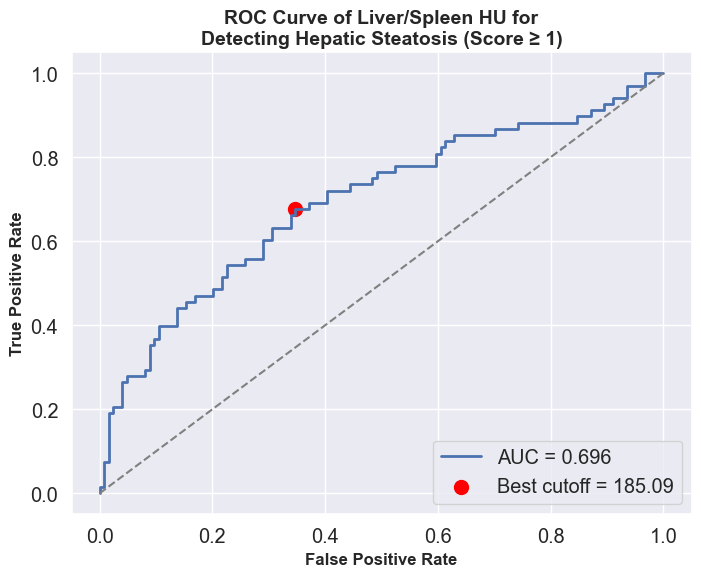

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Use combined_data as the base DataFrame
df = combined_data.copy()

# ✅ Choose subgroup here
subgroup = [
    "None",
    "NAFL",
    "Probable NASH",
    "NASH",
    "Cirrhosis",
]  # ← You can change this
df = df[df["NAFLD Type"].isin(subgroup)].copy()

# Define the target variable
df["Fibrosis Label"] = (df["Steatosis Score"].isin([2, 3])).astype(int)
target = "Fibrosis Label"

# Define feature
df["VFI - VFA(Volume)"] = df["VFI"] - 0.44 * df["VFA (Volume)"]
feature = "VFI - VFA(Volume)"
X = df[feature]
y = df[target]

# Calculate AUC
auc = roc_auc_score(y, X)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(X, y)

# Flip AUC and values if necessary
if auc < 0.5:
    auc = 1 - auc
    X = X.max() - X  # Flip values

# Determine if flipping is recommended
flip_decision = "Flip" if spearman_corr < 0 else "Do NOT Flip"
print(
    f"Feature: {feature}, AUC: {auc:.3f}, Spearman Corr: {spearman_corr:.3f}, Flip Decision: {flip_decision}"
)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, X)

# Calculate Youden’s J statistic to find best cutoff
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line

# Annotate best cutoff
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)
plt.title(
    "ROC Curve of Liver/Spleen HU for\nDetecting Hepatic Steatosis (Score ≥ 1)",
    fontsize=14,
    fontweight="bold",
)  # plt.title(f"ROC Curve for {feature}({', '.join(subgroup)})", fontsize=14, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot (optional)
save_path = "./result_images/ROC_LiverSpleenHU_Score.png"  # ← Change filename as needed
plt.savefig(save_path, dpi=600, bbox_inches="tight")

plt.show()

In [243]:
# Use combined_data as the base DataFrame
df = combined_data.copy()

# ✅ Choose subgroup here
subgroup = [
    "None",
    "NAFL",
    "Probable NASH",
    "NASH",
    "Cirrhosis",
]  # ← You can change this
df = df[df["NAFLD Type"].isin(subgroup)].copy()

In [244]:
df.columns.to_list()

['ID',
 'Sex',
 'Age',
 'Birth Date',
 'Steatosis Score',
 'NASH',
 'Fibrosis Stage',
 'NAFLD Type',
 'Death',
 'Death Date',
 'Weight',
 'Height',
 'Waist to Height',
 'Waist',
 'BMI',
 'Last F/U',
 'Smoking',
 'Ascites',
 'Ascites_Date',
 'VB',
 'VB_Date',
 'HEP',
 'HEP_Date',
 'HRS',
 'HRS_Date',
 'LT',
 'LT_Date',
 'FS_date',
 'CT_B Date',
 'SBP',
 'DBP',
 'LSM',
 'CAP',
 'AST',
 'ALT',
 'FIB-4',
 '당뇨병/당뇨병 전단계 유무',
 'PLT',
 'PT INR',
 'Alb',
 'Glucose',
 'TG',
 'VFI',
 'SFI',
 'TFI',
 'SMI',
 'VFA (Volume)',
 'SFA (Volume)',
 'SMA (Volume)',
 'Spleen (Volume)',
 'Liver (Volume)',
 'VFA (Area)',
 'SFA (Area)',
 'SMA (Area)',
 'VFA (Attenuation)',
 'SFA (Attenuation)',
 'SMA (Attenuation)',
 'Liver/Spleen Volume',
 'Liver/Spleen HU',
 'Liver (HU)',
 'Spleen (HU)',
 'Liver (PDFF)',
 'LRE',
 'LRE Date',
 'Fibrosis',
 'Fibrosis_group',
 'LRE Original']

In [ ]:
features = [
    "Sex",
    "Waist",
    # "Smoking",
    "SBP",
    "DBP",
    "LSM",
    "CAP",
    "AST",
    "ALT",
    "Weight",
    "Height",
    # "당뇨병/당뇨병 전단계 유무",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "TG",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
    "BMI",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "Waist to Height",
    "Age",
    "FIB-4",
]

corrected_results = []
for col in features:
    x = df[col]
    y = df["Advanced Fibrosis"]

    if x.isnull().any() or y.isnull().any():
        continue
    try:
        auc = roc_auc_score(y, x)
        corr = np.corrcoef(x, y)[0, 1]
        sign = np.sign(corr)

        if sign < 0:
            auc = 1 - auc  # 방향 보정

        corrected_results.append(
            (col, auc, corr, "negative" if sign < 0 else "positive")
        )

    except:
        continue

auc_df = pd.DataFrame(
    corrected_results, columns=["Feature", "Corrected AUC", "Corr", "Direction"]
)
auc_df = auc_df.sort_values("Corrected AUC", ascending=False).reset_index(drop=True)
display(auc_df)

,Feature,Corrected AUC,Corr,Direction
0,LSM,0.894391,0.487557,positive
1,FIB-4,0.767233,0.108691,positive
2,SMA (Volume),0.710861,-0.171134,negative
3,PLT,0.708506,-0.257301,negative
4,Age,0.691737,0.282573,positive
5,Height,0.684387,-0.261379,negative
6,SMI,0.676324,-0.147577,negative
7,PT INR,0.655987,0.256628,positive
8,Weight,0.634508,-0.208751,negative
9,SMA (Area),0.631511,-0.177580,negative


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)


# Apply cutoff to get predictions


y_pred = (X >= best_cutoff).astype(int)


# Evaluation metrics


accuracy = accuracy_score(y, y_pred)


precision = precision_score(y, y_pred)


recall = recall_score(y, y_pred)


f1 = f1_score(y, y_pred)


conf_matrix = confusion_matrix(y, y_pred)


# Print results


print("\n🔍 Evaluation Metrics")


print(f"Accuracy:  {accuracy:.3f}")


print(f"Precision: {precision:.3f}")


print(f"Recall:    {recall:.3f}")


print(f"F1-score:  {f1:.3f}")


print("\nConfusion Matrix:")


print(conf_matrix)


print(f"Best cutoff: {best_cutoff}")


🔍 Evaluation Metrics
Accuracy:  0.638
Precision: 0.495
Recall:    0.598
F1-score:  0.541

Confusion Matrix:
[[97 50]
 [33 49]]
Best cutoff: 191.82818138584787


In [65]:
# ✅ Choose subgroup here
subgroup = [
    "None",
    "NAFL",
    "Probable NASH",
    "NASH",
    "Cirrhosis",
]  # ← You can change this

# Step 1: Filter the data where NASH == 1
nash_data = combined_data[combined_data["NAFLD Type"].isin(subgroup)].copy()
nash_data["baseline_date"] = nash_data[["CT_B date", "FS_date"]].min(axis=1)

nash_data["event_observed_RFS"] = nash_data["LRE"]
nash_data["RFS_days"] = np.where(
    nash_data["LRE"] == 0,
    (
        pd.to_datetime("2025-02-12") - nash_data["baseline_date"]
    ).dt.days,  # If LRE == 0, use Last F/U
    (
        nash_data["LRE Date"] - nash_data["baseline_date"]
    ).dt.days,  # If LRE == 1, use LRE Date
)

# Step 2: Split into matched_treated (LRE == 1) and matched_control (LRE == 0)
# matched_treated = nash_data[nash_data["NAFLD Type"].isin(["NAFL","Probable NASH", "NASH", "Cirrhosis"])].reset_index(drop=True)
# matched_control = nash_data[nash_data["NAFLD Type"].isin(["None"])].reset_index(drop=True)

# Step 2: Split into matched_treated (LRE == 1) and matched_control (LRE == 0)
nash_data["VFI - VFA(Volume)"] = nash_data["VFI"] - 0.44 * nash_data["VFA (Volume)"]

matched_treated = nash_data[nash_data["Liver/Spleen HU"] >= 0.8].reset_index(drop=True)
matched_control = nash_data[nash_data["Liver/Spleen HU"] < 0.8].reset_index(drop=True)

# Display the sizes of the new datasets
print(f"Matched Treated: {matched_treated.shape}")
print(f"Matched Control: {matched_control.shape}")

Matched Treated: (152, 82)
Matched Control: (77, 82)


In [66]:
len(nash_data)

229

In [67]:
# Identify rows where RFS_days is negative
negative_rfs_rows = nash_data[nash_data["RFS_days"] < 0]
negative_rfs_rows

,ID,Sex,Birth Date,Age,Steatosis Score,Fibrosis Stage,NASH,NAFLD Type,Death Date,Death,Waist to Height,Waist,BMI_C,BMI,Height,Weight,Last F/U,Smoking,Ascites,Ascites_Date,VB,VB_Date,HEP,HEP_Date,HRS,HRS_Date,LT,LT_Date,SBP,DBP,VFA (Volume),SMI,TFI,SFI,VFI,SFA (Volume),Spleen (Volume),VFA (Area),SFA (Area),SMA (Area),VFA (Attenuation),SFA (Attenuation),SMA (Attenuation),Liver/Spleen Volume,Liver/Spleen HU,Liver (HU),Spleen (HU),Liver (PDFF),CT_B date,FS_date,LSM,LSM_C,CAP,AST,ALT,T.bil,PLT,PT INR,Alb,Glucose,HbA1c,eGFR,T.chol,HDL,LDL,TG,당뇨병/당뇨병 전단계 유무,FIB-4,FIB-4_C,고혈압유무,이상지질혈증 유무,Ischemic Heart Diseae 유무,Cerebrovascualr disease 유무,Nephropathy 유무,LRE,LRE Date,Fibrosis,LRE Original,baseline_date,event_observed_RFS,RFS_days,VFI - VFA(Volume)


In [69]:
nash_data["RFS_days"].isna().sum()

np.int64(0)

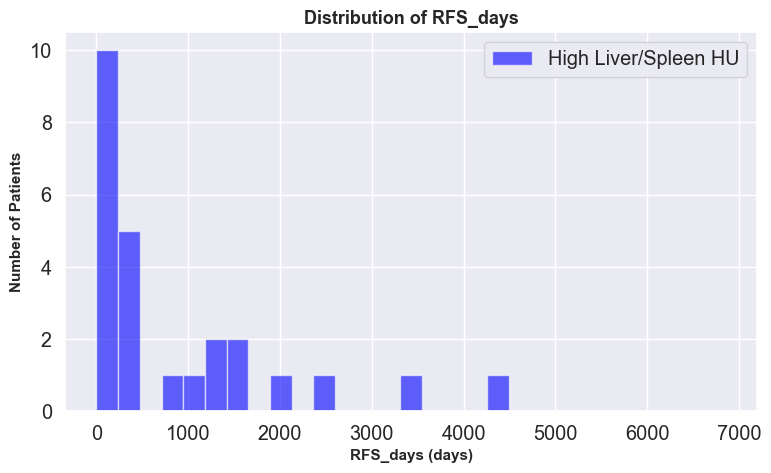

In [70]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 5))
bins = np.linspace(0, max(nash_data["RFS_days"]), 30)

plt.hist(
    nash_data[nash_data["LRE"] == 1]["RFS_days"],
    bins=bins,
    alpha=0.6,
    label="High Liver/Spleen HU",
    color="blue",
)

# Labels and formatting
plt.title("Distribution of RFS_days", fontsize=13, fontweight="bold")
plt.xlabel("RFS_days (days)", fontsize=11, fontweight="bold")
plt.ylabel("Number of Patients", fontsize=11, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
np.set_printoptions(suppress=True, formatter={"float_kind": "{:.0f}".format})

In [73]:
nash_data[nash_data["LRE"] == 1]["RFS_days"].unique()

array([338, 4359, 1, 68, 1025, 2458, 3320, 1623, 377, 317, 48, 21, 1371,
       13, 2098, 900, 52, 1526, 329, 1410, 2, 5, 445])

## Kaplan-Meier Plots along with "Number at Risk"

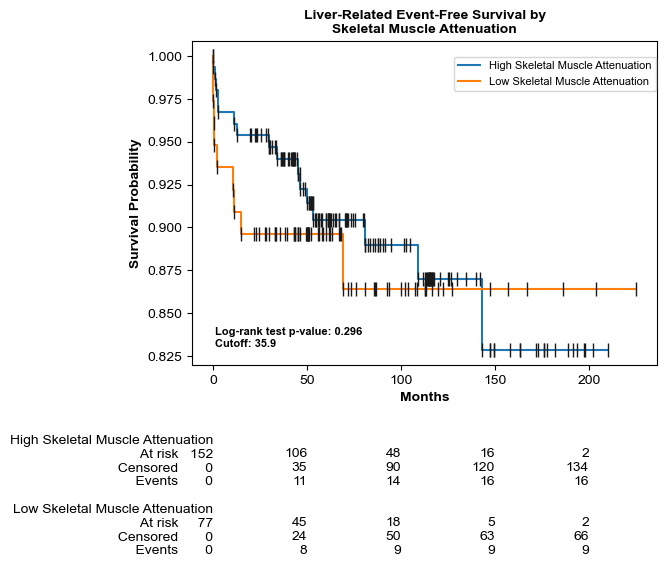

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
import numpy as np

# Define the metric and cutoff you want to analyze
metric = "Skeletal Muscle Attenuation"  # Change this to "Liver/Spleen HU", "LSM", etc.
cutoff = 35.90  # Replace with your actual cutoff value

# Label for plot lines
high_label = f"High {metric}"
low_label = f"Low {metric}"

# Create Kaplan-Meier objects
kmf_rfs_high = KaplanMeierFitter()
kmf_rfs_low = KaplanMeierFitter()

# Fit the data
kmf_rfs_high.fit(
    durations=matched_treated["RFS_days"] / 30.44,
    event_observed=matched_treated["event_observed_RFS"],
    label=high_label,
)
kmf_rfs_low.fit(
    durations=matched_control["RFS_days"] / 30.44,
    event_observed=matched_control["event_observed_RFS"],
    label=low_label,
)

# Perform the log-rank test
results_rfs = logrank_test(
    durations_A=matched_treated["RFS_days"],
    durations_B=matched_control["RFS_days"],
    event_observed_A=matched_treated["event_observed_RFS"],
    event_observed_B=matched_control["event_observed_RFS"],
)

# Calculate p-value
two_sided_p_value = results_rfs.p_value
test_statistic = results_rfs.test_statistic
one_sided_p_value = (
    two_sided_p_value / 2 if test_statistic > 0 else 1 - (two_sided_p_value / 2)
)

# Plot
plt.rcdefaults()
plt.figure(figsize=(6, 4.2))
plt.rcParams["font.family"] = "Arial"
ax = plt.subplot(111)

# Plot KM curves
kmf_rfs_high.plot_survival_function(ax=ax, ci_show=False, legend=False)
kmf_rfs_low.plot_survival_function(ax=ax, ci_show=False, legend=False)

# Axis labels
ax.set_xlabel("Months", fontweight="bold")
ax.set_ylabel("Survival Probability", fontweight="bold")

# Add tick marks for events
for time_point in kmf_rfs_high.event_table.index:
    if time_point >= 0:
        prob = kmf_rfs_high.survival_function_.at[time_point, high_label]
        ax.plot(time_point, prob, "k|", markersize=10)

for time_point in kmf_rfs_low.event_table.index:
    if time_point >= 0:
        prob = kmf_rfs_low.survival_function_.at[time_point, low_label]
        ax.plot(time_point, prob, "k|", markersize=10)

# Annotate p-value and cutoff
p_value_text = f"Log-rank test p-value: {one_sided_p_value:.3f}\n" f"Cutoff: {cutoff}"
ax.text(
    0,
    0.05,
    p_value_text,
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    fontsize=8,
    fontweight="bold",
)

# Add number at risk table
add_at_risk_counts(kmf_rfs_high, kmf_rfs_low, ax=ax)

# Adjust the text alignment for "Number at risk"
for text in ax.texts[-2:]:
    text.set_x(text.get_position()[0] + 0.05)

# Make the "Number at risk" title bold
for text in ax.texts:
    if "Number at risk" in text.get_text():
        text.set_fontweight("bold")

# Show axis lines
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

# Legend
ax.legend(bbox_to_anchor=(0.55, 0.97), loc="upper left", title="", fontsize=8)

import re

# Clean the metric name to be filename-safe
safe_metric = re.sub(r'[\\\\/:*?"<>|]', "_", metric)

# Save figure
plt.title(
    f"Liver-Related Event-Free Survival by\n{metric}", fontsize=10, fontweight="bold"
)

plt.savefig(f"{safe_metric}_LRE.jpg", bbox_inches="tight", dpi=600)
plt.show()

In [22]:
one_sided_p_value

0.2962613263555584

In [23]:
# Find median RFS
median_rfs_ic = kmf_rfs_high.median_survival_time_
median_rfs_cn = kmf_rfs_low.median_survival_time_

print(f"Median RFS for High group: {median_rfs_ic:.2f} months")
print(f"Median RFS for Low group: {median_rfs_cn:.2f} months")

Median RFS for High group: inf months
Median RFS for Low group: inf months


# Univariable Analysis (Crude HR) by Subgroup

In [112]:
matched_df = nash_data.copy()

In [113]:
matched_df["NAFLD Type"].value_counts()

NAFLD Type
NASH             70
NAFL             69
Probable NASH    45
Cirrhosis        25
None             20
Name: count, dtype: int64

In [114]:
import warnings
from lifelines.utils import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [26]:
matched_df.columns

Index(['ID', 'Sex', 'Birth Date', 'Age', 'Steatosis Score', 'Fibrosis Stage',
       'NASH', 'NAFLD Type', 'Death Date', 'Death', 'Waist to Height', 'Waist',
       'BMI_C', 'BMI', 'Height', 'Weight', 'Last F/U', 'Smoking', 'Ascites',
       'Ascites_Date', 'VB', 'VB_Date', 'HEP', 'HEP_Date', 'HRS', 'HRS_Date',
       'LT', 'LT_Date', 'SBP', 'DBP', 'VFA (Volume)', 'SMI', 'TFI', 'SFI',
       'VFI', 'SFA (Volume)', 'SMA (Volume)', 'Spleen (Volume)', 'VFA (Area)',
       'SFA (Area)', 'SMA (Area)', 'VFA (Attenuation)', 'SFA (Attenuation)',
       'SMA (Attenuation)', 'Liver/Spleen Volume', 'Liver/Spleen HU',
       'Liver (HU)', 'Spleen (HU)', 'Liver (PDFF)', 'CT_B date', 'FS_date',
       'LSM', 'LSM_C', 'CAP', 'AST', 'ALT', 'T.bil', 'PLT', 'PT INR', 'Alb',
       'Glucose', 'HbA1c', 'eGFR', 'T.chol', 'HDL', 'LDL', 'TG',
       '당뇨병/당뇨병 전단계 유무', 'FIB-4', 'FIB-4_C', '고혈압유무', '이상지질혈증 유무',
       'Ischemic Heart Diseae 유무', 'Cerebrovascualr disease 유무',
       'Nephropathy 유무', 'LRE', 'LRE

In [ ]:
continuous_vars = [
    # "Sex",
    "Waist",
    # "Smoking",
    "SBP",
    "DBP",
    "LSM",
    "CAP",
    "AST",
    "ALT",
    "Weight",
    "Height",
    # "당뇨병/당뇨병 전단계 유무",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "TG",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
    "BMI",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "Waist to Height",
    "Age",
    "FIB-4",
]


# continuous_vars 중복원소 제거 후 list로 변환
continuous_vars = list(set(continuous_vars))

In [ ]:
from patsy import dmatrix
import statsmodels.api as sm

# 1. spline basis 생성 (R과 거의 동일 방식)
spline_basis = dmatrix(
    "bs(AST, df=4, include_intercept=False)", data=df, return_type="dataframe"
)

# 2. 로지스틱 회귀 모델 (Advanced Fibrosis 기준)
model = sm.Logit(df["Advanced Fibrosis"], spline_basis).fit(disp=0)

# 3. 결과 확인
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:      Advanced Fibrosis   No. Observations:                  192
Model:                          Logit   Df Residuals:                      187
Method:                           MLE   Df Model:                            4
Date:                Fri, 18 Apr 2025   Pseudo R-squ.:                 0.04617
Time:                        09:34:53   Log-Likelihood:                -104.02
converged:                      False   LL-Null:                       -109.05
Covariance Type:            nonrobust   LLR p-value:                   0.03928
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -4.2063      1.459     -2.882      0.004      -7.067      -1.346
bs(AST, df=4, include_intercept=False)

c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


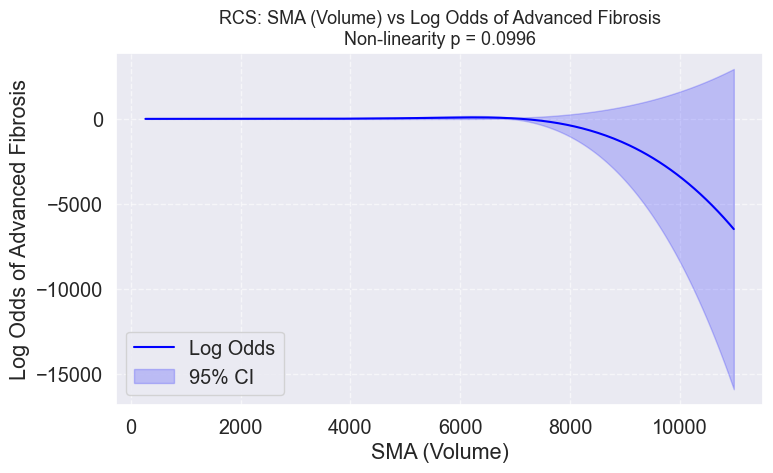

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
import statsmodels.api as sm
from scipy.stats import chi2

# 1. X, y
variable = "SMA (Volume)"  # ← Change this to the variable you want to analyze

x = df[variable]
y = df["Advanced Fibrosis"]

# 2. 전체 모델 (RCS)
spline_basis = dmatrix(
    "bs(x, df=4, include_intercept=False)", {"x": x}, return_type="dataframe"
)
model = sm.Logit(y, spline_basis).fit(disp=0)

# 3. 선형 모델
linear_basis = dmatrix("x", {"x": x}, return_type="dataframe")
linear_model = sm.Logit(y, linear_basis).fit(disp=0)

# 4. LRT for non-linearity
lrt_stat = 2 * (model.llf - linear_model.llf)
df_diff = model.df_model - linear_model.df_model
p_value = chi2.sf(lrt_stat, df_diff)

# 5. 예측용 X
x_pred = np.linspace(x.min(), x.max(), 300)
spline_pred = dmatrix(
    "bs(x_pred, df=4, include_intercept=False)",
    {"x_pred": x_pred},
    return_type="dataframe",
)

Xp = spline_pred.values
beta = model.params.values
cov = model.cov_params().values

log_odds = Xp @ beta
se = np.sqrt(np.sum((Xp @ cov) * Xp, axis=1))
lower = log_odds - 1.96 * se
upper = log_odds + 1.96 * se

# 6. 시각화
plt.figure(figsize=(8, 5))
plt.plot(x_pred, log_odds, color="blue", label="Log Odds")
plt.fill_between(x_pred, lower, upper, color="blue", alpha=0.2, label="95% CI")
plt.title(
    f"RCS: {variable} vs Log Odds of Advanced Fibrosis\nNon-linearity p = {p_value:.4f}",
    fontsize=13,
)
plt.xlabel(f"{variable}")
plt.ylabel("Log Odds of Advanced Fibrosis")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import chi2

# 전체 모델 (RCS 포함)
full_basis = dmatrix(
    "bs(x, df=4, include_intercept=False)", {"x": x}, return_type="dataframe"
)
full_model = sm.Logit(y, full_basis).fit(disp=0)

# 선형 모델
linear_basis = dmatrix("x", {"x": x}, return_type="dataframe")
linear_model = sm.Logit(y, linear_basis).fit(disp=0)

# LRT
lrt_stat = 2 * (full_model.llf - linear_model.llf)
df_diff = full_model.df_model - linear_model.df_model
p_value = chi2.sf(lrt_stat, df_diff)

print("Non-linearity p-value:", p_value)

Non-linearity p-value: 0.003426434074257019


c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


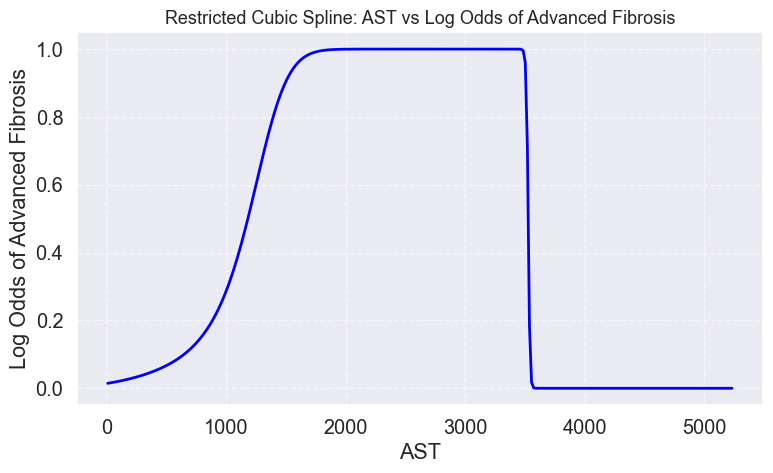

In [ ]:
# 5. log odds 직접 계산 (overflow 방지)
log_odds = np.dot(x_spline, model.params)

# 6. 시각화
plt.figure(figsize=(8, 5))
plt.plot(x_range, log_odds, color="blue", linewidth=2)
plt.title("Restricted Cubic Spline: AST vs Log Odds of Advanced Fibrosis", fontsize=13)
plt.xlabel("AST")
plt.ylabel("Log Odds of Advanced Fibrosis")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [39]:
continuous_vars = [
    # "Sex",
    "Waist",
    # "Smoking",
    "SBP",
    "DBP",
    "LSM",
    "CAP",
    "AST",
    "ALT",
    "Weight",
    "Height",
    # "당뇨병/당뇨병 전단계 유무",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "TG",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
    "BMI",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "Waist to Height",
    "Age",
    "FIB-4",
]


# continuous_vars 중복원소 제거 후 list로 변환
continuous_vars = list(set(continuous_vars))

In [190]:
# Multivariate analysis for all groups
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_data is already preprocessed and available

# Define continuous and categorical variables
# continuous_vars = [
#     "Age",
#     "Weight",
#     "Height",
#     "Waist to Height",
#     "Waist",
#     "SBP",
#     "DBP",
#     "LSM",
#     "CAP",
#     "AST",
#     "ALT",
#     "당뇨병/당뇨병 전단계 유무",
#     "PLT",
#     "PT INR",
#     "Alb",
#     "Glucose",
#     "TG",
#     "VFA (Volume)",
#     "SFA (Volume)",
#     "SMA (Volume)",
#     "Spleen (Volume)",
#     "Liver (Volume)",
#     "VFA (Area)",
#     "SFA (Area)",
#     "SMA (Area)",
#     "VFA (Attenuation)",
#     "SFA (Attenuation)",
#     "SMA (Attenuation)",
#     "Liver/Spleen Volume",
#     "Liver/Spleen HU",
#     "Liver (HU)",
#     "Spleen (HU)",
#     "Liver (PDFF)",
#     "BMI",
#     "VFI",
#     "SFI",
#     "TFI",
#     "SMI",
#     "Waist to Height",
#     "Age",
#     "FIB-4",
# ]


# Convert continuous variables to binary (above/below median)
for var in continuous_vars:
    median_value = df[var].median()
    df[f"{var}_above_median"] = (df[var] > median_value).astype(int)

# List of categorical variables
categorical_vars = [
    "Sex",
    "Smoking",
    "당뇨병/당뇨병 전단계 유무",
    # "고혈압유무",
    # "이상지질혈증 유무",
    # "Ischemic Heart Diseae 유무",
    # "Cerebrovascualr disease 유무",
    # "Nephropathy 유무",
]

# Define the list of covariates for the Cox model
covariates = [f"{var}_above_median" for var in continuous_vars] + [
    cat for cat in categorical_vars
]

In [191]:
covariates

['Liver/Spleen Volume_above_median',
 'VFA (Volume)_above_median',
 'SMA (Attenuation)_above_median',
 'Liver (PDFF)_above_median',
 'SFA (Area)_above_median',
 'BMI_above_median',
 'Spleen (HU)_above_median',
 'Waist_above_median',
 'SBP_above_median',
 'FIB-4_above_median',
 'PLT_above_median',
 'TFI_above_median',
 'Age_above_median',
 'Alb_above_median',
 'LSM_above_median',
 'SMA (Volume)_above_median',
 'SFI_above_median',
 'Waist to Height_above_median',
 'SMA (Area)_above_median',
 'SFA (Attenuation)_above_median',
 'Glucose_above_median',
 'Height_above_median',
 'AST_above_median',
 'VFI_above_median',
 'TG_above_median',
 'VFA (Attenuation)_above_median',
 'Liver/Spleen HU_above_median',
 'Weight_above_median',
 'ALT_above_median',
 'SFA (Volume)_above_median',
 'Liver (HU)_above_median',
 'PT INR_above_median',
 'CAP_above_median',
 'DBP_above_median',
 'VFA (Area)_above_median',
 'Liver (Volume)_above_median',
 'Spleen (Volume)_above_median',
 'SMI_above_median',
 'Sex',
 

In [116]:
# Calculate the median values for continuous variables
median_values = matched_df[continuous_vars].median()

# Print the median values for each variable
print("Median values for continuous variables:")
print(median_values)

Median values for continuous variables:
Age                      56.000000
Weight                   72.000000
Height                  165.000000
Waist to Height           5.469079
Waist                   910.159119
BMI                      26.370238
VFI                     375.647508
SFI                     515.137033
TFI                     890.144458
SMI                      47.988166
VFA (Volume)           1032.168688
SFA (Volume)           1382.266000
Spleen (Volume)         199.286563
VFA (Area)              149.392520
SFA (Area)              179.932109
SMA (Area)              130.988740
VFA (Attenuation)       -96.838936
SFA (Attenuation)      -101.844116
SMA (Attenuation)        35.900383
Liver/Spleen Volume       7.683849
Liver/Spleen HU           0.932730
Liver (HU)               46.538898
Spleen (HU)              46.524864
Liver (PDFF)             11.066558
LSM                       7.700000
CAP                     280.000000
AST                      43.000000
ALT            

In [99]:
covariates_group = covariates + ["group"]

In [117]:
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
import pandas as pd

# Placeholder for significant variables
significant_covariates_rfs = []
significant_covariates_os_css = []


# Function to perform univariable Cox regression and collect significant variables
def univariable_analysis(matched_df, duration_col, event_col, covariates):
    significant_vars = []
    skipped_vars = []

    for var in covariates:
        try:
            # Drop NA values to avoid fitting errors
            df_subset = matched_df[[duration_col, event_col, var]].dropna()

            # Skip if variable has no variation
            if df_subset[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            cph = CoxPHFitter()
            cph.fit(df_subset, duration_col=duration_col, event_col=event_col)

            p_value = cph.summary.loc[var, "p"]
            if p_value < 0.05:
                significant_vars.append(var)

        except ConvergenceError as e:
            print(f"⚠️ Skipping '{var}' due to convergence error.")
            skipped_vars.append(var)
        except Exception as e:
            print(f"⚠️ Skipping '{var}' due to unexpected error: {e}")
            skipped_vars.append(var)

    print(
        f"\n✅ Finished univariable analysis. Skipped {len(skipped_vars)} variables due to issues."
    )
    return significant_vars


# Run for RFS
significant_covariates_rfs = univariable_analysis(
    matched_df, "RFS_days", "event_observed_RFS", covariates
)
print("\n🟢 Significant covariates for RFS (p < 0.05):")
print(significant_covariates_rfs)

# Example for OS/CSS (uncomment if needed)
# significant_covariates_os_css = univariable_analysis(matched_df, 'OS_CSS_days', 'Death', covariates + ["group"])
# print("\n🟢 Significant covariates for OS/CSS (p < 0.05):")
# print(significant_covariates_os_css)


✅ Finished univariable analysis. Skipped 0 variables due to issues.

🟢 Significant covariates for RFS (p < 0.05):
['Height_above_median', 'SMA (Area)_above_median', 'SMA (Attenuation)_above_median', 'LSM_above_median', 'AST_above_median', 'PLT_above_median', 'LDL_above_median', 'FIB-4_above_median', 'Sex', 'Cerebrovascualr disease 유무']


In [118]:
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError


def backward_stepwise_cox(df, duration_col, event_col, covariates, threshold=0.05):
    remaining_vars = covariates.copy()
    cph = CoxPHFitter()

    while len(remaining_vars) > 0:
        try:
            cph.fit(
                df[[duration_col, event_col] + remaining_vars],
                duration_col=duration_col,
                event_col=event_col,
            )
            summary = cph.summary
            max_p = summary["p"].max()
            if max_p > threshold:
                worst_var = summary["p"].idxmax()
                remaining_vars.remove(worst_var)
            else:
                break
        except ConvergenceError as e:
            print(f"⚠️ Convergence error with variables: {remaining_vars}")
            break
        except Exception as e:
            print(f"❌ Unexpected error: {e}")
            break

    # Final model with selected variables
    cph.fit(
        df[[duration_col, event_col] + remaining_vars],
        duration_col=duration_col,
        event_col=event_col,
    )
    return cph, remaining_vars


# Run backward stepwise for RFS
final_cph_rfs, final_vars_rfs = backward_stepwise_cox(
    matched_df,
    duration_col="RFS_days",
    event_col="event_observed_RFS",
    covariates=significant_covariates_rfs,  # your list from univariable analysis
    threshold=0.05,
)

# Print final model summary
final_cph_rfs.print_summary()

<lifelines.CoxPHFitter: fitted with 229 total observations, 204 right-censored observations>
             duration col = 'RFS_days'
                event col = 'event_observed_RFS'
      baseline estimation = breslow
   number of observations = 229
number of events observed = 25
   partial log-likelihood = -115.83
         time fit was run = 2025-04-17 18:25:53 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
SMA (Area)_above_median    -1.45      0.23      0.51           -2.46           -0.45                0.09                0.64
LSM_above_median            1.33      3.77      0.43            0.47            2.18                1.61                8.85
Cerebrovascualr disease 유무  1.62      5.04      0.64            0.37            2.86                1.45               17.51

                            cmp to     z      p  -log2(p)
covariate                                                
SMA (Area)_above_median       0.00 -2.83 <0.005      7.74
LSM_above_median              0.00  3.05 <0.005      8.78
Cerebrovascualr disease 유무    0.00  2.55   0.01      6.53
---
Concordance = 0.74
Partial AIC = 237.66
log-likelihood ratio test = 24.45 on 3 df
-log2(p) of ll-ratio test = 15.60

In [119]:
import pandas as pd
from lifelines import CoxPHFitter

# Assuming matched_df is your dataset and already contains binary covariates

cph_adjusted = CoxPHFitter()
cph_adjusted.fit(
    matched_df[["RFS_days", "event_observed_RFS"] + final_vars_rfs],
    duration_col="RFS_days",
    event_col="event_observed_RFS",
)

# Extract and format the result
summary = cph_adjusted.summary
summary["Adjusted HR (95% CI)"] = summary.apply(
    lambda row: f"{row['exp(coef)']:.2f} ({row['exp(coef) lower 95%']:.2f}-{row['exp(coef) upper 95%']:.2f})",
    axis=1,
)
summary["P-value"] = summary["p"].round(4)

# Final table
result_table = summary[["Adjusted HR (95% CI)", "P-value"]]
print(result_table)

                           Adjusted HR (95% CI)  P-value
covariate                                               
SMA (Area)_above_median        0.23 (0.09-0.64)   0.0047
LSM_above_median               3.77 (1.61-8.85)   0.0023
Cerebrovascualr disease 유무    5.04 (1.45-17.51)   0.0108


In [120]:
import pandas as pd

# Simulated matched_df structure with relevant columns
# In real use, matched_df should be your actual dataset
# Columns: group (1: SGLT2-inh users, 0: non-users), event_observed_RFS, RFS_days,
#          and categorical cutoffs like LSM_above_median, AST_above_median, etc.


# Define a function to calculate events, person-years, and incidence rate
def calculate_incidence_stats(df, group_col, time_col, event_col):
    total_events = df[event_col].sum()
    total_person_years = df[time_col].sum() / 365.25
    incidence_rate = total_events / total_person_years * 10000  # per person-year
    return total_events, total_person_years, incidence_rate


# Define a function to run Cox regression (crude model) for a binary exposure
from lifelines import CoxPHFitter


def run_crude_cox(df, exposure, duration_col, event_col):
    cph = CoxPHFitter()
    try:
        cph.fit(
            df[[duration_col, event_col, exposure]],
            duration_col=duration_col,
            event_col=event_col,
        )
        summary = cph.summary
        hr = summary.loc[exposure, "exp(coef)"]
        lower = summary.loc[exposure, "exp(coef) lower 95%"]
        upper = summary.loc[exposure, "exp(coef) upper 95%"]
        p_value = summary.loc[exposure, "p"]
        return hr, lower, upper, p_value
    except:
        return None, None, None, None


# Define all exposure variables you want to stratify by
exposures = [
    "Height_above_median",
    "SMA (Area)_above_median",
    "SMA (Attenuation)_above_median",
    "LSM_above_median",
    "AST_above_median",
    "PLT_above_median",
    "LDL_above_median",
    "FIB-4_above_median",
    "Sex",
    "Cerebrovascualr disease 유무",
]

# Prepare results
results = []

# Assume matched_df is defined
for var in exposures:
    subgroups = matched_df[var].dropna().unique()
    for val in sorted(subgroups, reverse=True):  # Ensure 1 comes before 0
        subset = matched_df[matched_df[var] == val]
        events, py, ir = calculate_incidence_stats(
            subset, var, "RFS_days", "event_observed_RFS"
        )

        if val == 1:
            hr, low, high, p = run_crude_cox(
                matched_df, var, "RFS_days", "event_observed_RFS"
            )
            hr_str = f"{hr:.2f} ({low:.2f}-{high:.2f})" if hr else "NA"
        else:
            hr_str = "1.00 (reference)"
            p = ""

        results.append(
            {
                "Variable": var,
                "Group": f"{var} = {val}",
                "Events": int(events),
                "Person-years": round(float(py), 2),
                "Incidence Rate": round(ir.item(), 4),
                "Crude HR (95% CI)": hr_str,
                "P-value": round(p.item(), 4) if p != "" else "",
            }
        )

In [121]:
results

[{'Variable': 'Height_above_median',
  'Group': 'Height_above_median = 1',
  'Events': 5,
  'Person-years': 709.88,
  'Incidence Rate': 70.4341,
  'Crude HR (95% CI)': '0.26 (0.10-0.69)',
  'P-value': 0.0068},
 {'Variable': 'Height_above_median',
  'Group': 'Height_above_median = 0',
  'Events': 20,
  'Person-years': 734.92,
  'Incidence Rate': 272.138,
  'Crude HR (95% CI)': '1.00 (reference)',
  'P-value': ''},
 {'Variable': 'SMA (Area)_above_median',
  'Group': 'SMA (Area)_above_median = 1',
  'Events': 5,
  'Person-years': 751.15,
  'Incidence Rate': 66.5645,
  'Crude HR (95% CI)': '0.24 (0.09-0.65)',
  'P-value': 0.0046},
 {'Variable': 'SMA (Area)_above_median',
  'Group': 'SMA (Area)_above_median = 0',
  'Events': 20,
  'Person-years': 693.65,
  'Incidence Rate': 288.3283,
  'Crude HR (95% CI)': '1.00 (reference)',
  'P-value': ''},
 {'Variable': 'SMA (Attenuation)_above_median',
  'Group': 'SMA (Attenuation)_above_median = 1',
  'Events': 7,
  'Person-years': 758.28,
  'Incidenc

# Fibrosis에 대한 OR

In [122]:
matched_df["당뇨병/당뇨병 전단계 유무2"] = matched_df[
    "당뇨병/당뇨병 전단계 유무"
].replace({1: 1, 2: 1})

In [123]:
# Load the uploaded Excel file to inspect its structure and contents
file_path = "./Deepcatch 2025-1-14.xlsx"
df = pd.read_excel(file_path, header=2)

# Filter rows where "Fibrosis stage" is not null
filtered_df = df[df["Fibrosis stage"].notnull()]

# Extract "(실명)등록번호" column as a vector (list)
patient_ids = filtered_df["(실명)등록번호"].tolist()

# View result
len(patient_ids)

169

In [124]:
matched_df_original = matched_df.copy()

In [125]:
mathced_df = matched_df_original.copy()
matched_df = matched_df[matched_df["ID"].isin(patient_ids)]
matched_df.shape

(157, 125)

# 본격적으로 시작

In [157]:
import pandas as pd

pd.set_option("display.max_columns", None)  # 모든 열 표시
pd.set_option("display.max_rows", None)  # 모든 열 표시
pd.set_option("display.expand_frame_repr", False)  # 가로로 긴 데이터프레임 줄바꿈 방지

In [ ]:
import pyreadstat
import pandas as pd

from lifelines import KaplanMeierFitter
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from psmpy import PsmPy
import numpy as np

path = "./2025-04-18_20-40_mod_wStea_2nd Preprocessing.csv"
# path = "./2025-04-18_20-40_mod_wStea_2nd Preprocessing.csv"  ##SMI 도움 없이 Fibrosis 채움
# path = "./2025-04-19_17-48_mod_wStea_2nd Preprocessing.csv" ##SMI 도움으로 FIbrsis 채움
# path = "./temp.csv"  # SMI 도움 받고, 피검사는 fS date에 가까운애들로로
# path = "./2025-04-20_20-58_mod_wStea_2nd Preprocessing.csv"
# path = "./2025-04-20_22-03_mod_wStea_2nd Preprocessing.csv"
# parth = "./2025-04-18_20-40_mod_wStea_2nd Preprocessing.csv"
df = pd.read_csv(path, na_values=["", "NaN"], keep_default_na=False)

In [196]:
df["당뇨병/당뇨병 전단계 유무2"] = df["당뇨병/당뇨병 전단계 유무"].replace({1: 1, 2: 1})

In [197]:
# Fibrosis 처리

df["Significant Fibrosis"] = (df["Fibrosis"] >= 2).astype(int)  # F2, F3, F4
df["Advanced Fibrosis"] = (df["Fibrosis"] >= 3).astype(int)  # F3, F4

In [198]:
# Steatosis 처리

df["Mild Steatosis"] = (df["Steatosis Score"] >= 1).astype(int)  # S1, S2, S3
df["Severe Steatosis"] = (df["Steatosis Score"] >= 2).astype(int)  # S2, S3

In [162]:
df.columns.tolist()

['ID',
 'Sex',
 'Birth Date',
 'Age',
 'Death',
 'Death Date',
 'Last F/U',
 'Smoking',
 'Steatosis Score',
 'Fibrosis',
 'Fibrosis Stage',
 'FIB-4',
 'NAFLD Type',
 'NAFLD Type_C',
 'NASH',
 'Weight',
 'Height',
 'BMI',
 'Waist',
 'Waist to Height',
 'SBP',
 'DBP',
 'AST',
 'ALT',
 'T.bil',
 'PLT',
 'PT INR',
 'Alb',
 'Glucose',
 'HbA1c',
 'eGFR',
 'T.chol',
 'HDL',
 'LDL',
 'TG',
 '당뇨병/당뇨병 전단계 유무',
 '고혈압유무',
 '이상지질혈증 유무',
 'Ischemic Heart Diseae 유무',
 'Cerebrovascualr disease 유무',
 'Nephropathy 유무',
 'LSM',
 'CAP',
 'Liver (PDFF)',
 'Liver (HU)',
 'Spleen (HU)',
 'Liver/Spleen HU',
 'Liver (Volume)',
 'Spleen (Volume)',
 'Liver/Spleen Volume',
 'VFA (Volume)',
 'SFA (Volume)',
 'SMA (Volume)',
 'VFA (Area)',
 'SFA (Area)',
 'SMA (Area)',
 'VFA (Attenuation)',
 'SFA (Attenuation)',
 'SMA (Attenuation)',
 'VFI',
 'SFI',
 'TFI',
 'SMI',
 'FS_date',
 'CT_B date',
 'LRE',
 'LRE Date',
 'Ascites',
 'Ascites_Date',
 'VB',
 'VB_Date',
 'HEP',
 'HEP_Date',
 'HRS',
 'HRS_Date',
 'LT',
 'LT_Dat

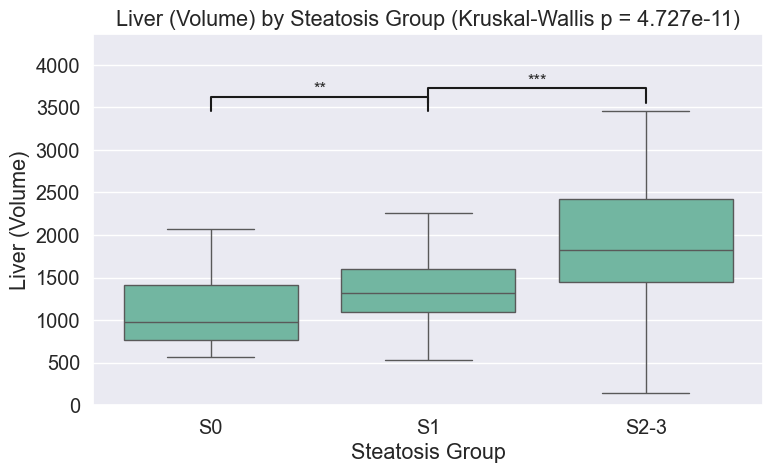

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

# 복사 및 전처리
temp_df = df.copy()
temp_df = temp_df[temp_df["Steatosis Score"].notna()].copy()
temp_df["Steatosis Score"] = temp_df["Steatosis Score"].astype(int)

# 그룹핑: S0, S1, S2-3
temp_df["Steatosis_group"] = temp_df["Steatosis Score"].map(
    lambda x: "S0" if x == 0 else "S1" if x == 1 else "S2-3"
)

subject = "Steatosis"

# variable = "TFI"
# variable = "Liver/Spleen HU"  # ← Change this to the variable you want to analyze
variable = "Liver (Volume)"  # ← Change this to the variable you want to analyze

group_var = "Steatosis_group"
group_order = ["S0", "S1", "S2-3"]

sns.set_palette("Set2")

# Kruskal-Wallis
grouped = temp_df.groupby(group_var)[variable]
stat, p_kw = kruskal(*[group for name, group in grouped])

q3 = temp_df[variable].quantile(0.75)

iqr = q3 - temp_df[variable].quantile(0.25)
y_max = q3 + 1.5 * iqr
# y_max = q3 + iqr
y_max *= 1.2

# Boxplot
plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=temp_df,
    x=group_var,
    y=variable,
    order=group_order,
    showfliers=False,
)
plt.ylim(0, y_max * 1.3)
plt.title(f"{variable} by {subject} Group (Kruskal-Wallis p = {p_kw:.3e})")
plt.xlabel(f"{subject} Group")
plt.ylabel(variable)

# Pairwise Mann-Whitney (인접 비교)
comparisons = [
    (group_order[i], group_order[i + 1]) for i in range(len(group_order) - 1)
]


for i, (g1, g2) in enumerate(comparisons):
    data1 = temp_df[temp_df[group_var] == g1][variable]
    data2 = temp_df[temp_df[group_var] == g2][variable]
    stat, p = mannwhitneyu(data1, data2)

    star = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"

    x1, x2 = group_order.index(g1), group_order.index(g2)
    y = y_max + (i + 1) * (y_max * 0.03)
    gap = y_max * 0.05
    ax.plot([x1, x1, x2, x2], [y, y + gap, y + gap, y], lw=1.5, c="k")
    ax.text((x1 + x2) / 2, y + gap, star, ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()

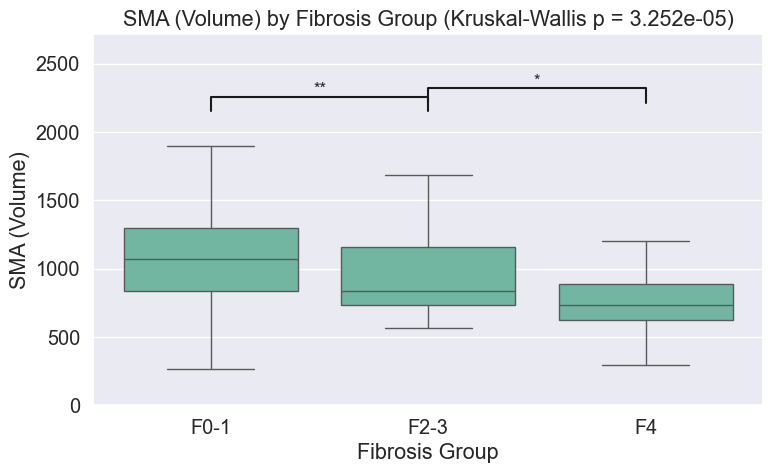

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools

# 복사 및 전처리
temp_df = df.copy()
temp_df = temp_df[temp_df["Fibrosis"].notna()].copy()
temp_df["Fibrosis"] = temp_df["Fibrosis"].astype(int)

subject = "Fibrosis"

# 그룹핑: F0-1, F2-3, F4
group_var = f"{subject}_group"

temp_df[group_var] = temp_df["Fibrosis"].map(
    lambda x: "F0-1" if x in [0, 1] else "F2-3" if x in [2, 3] else "F4"
)

group_order = ["F0-1", "F2-3", "F4"]


# # 그룹핑: F0-2, F3-4
# group_var = f"{subject}_group"

# temp_df[group_var] = temp_df["Fibrosis"].map(
#     lambda x: "F0-2" if x in [0, 1, 2] else "F3-4"
# )

# group_order = ["F0-2", "F3-4"]


variable = "SMA (Volume)"  # ← Change this to the variable you want to analyze


sns.set_palette("Set2")

# Kruskal-Wallis
grouped = temp_df.groupby(group_var)[variable]
stat, p_kw = kruskal(*[group for name, group in grouped])

q3 = temp_df[variable].quantile(0.75)

iqr = q3 - temp_df[variable].quantile(0.25)
y_max = q3 + 1.5 * iqr
# y_max = q3 + iqr
y_max *= 1.1

# Boxplot
plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=temp_df,
    x=group_var,
    y=variable,
    order=group_order,
    showfliers=False,
)
plt.ylim(0, y_max * 1.3)
plt.title(f"{variable} by {subject} Group (Kruskal-Wallis p = {p_kw:.3e})")
plt.xlabel(f"{subject} Group")
plt.ylabel(variable)

# Pairwise Mann-Whitney (인접 비교)
comparisons = [
    (group_order[i], group_order[i + 1]) for i in range(len(group_order) - 1)
]


for i, (g1, g2) in enumerate(comparisons):
    data1 = temp_df[temp_df[group_var] == g1][variable]
    data2 = temp_df[temp_df[group_var] == g2][variable]
    stat, p = mannwhitneyu(data1, data2)

    star = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"

    x1, x2 = group_order.index(g1), group_order.index(g2)
    y = y_max + (i + 1) * (y_max * 0.03)
    gap = y_max * 0.05
    ax.plot([x1, x1, x2, x2], [y, y + gap, y + gap, y], lw=1.5, c="k")
    ax.text((x1 + x2) / 2, y + gap, star, ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.show()

## 3 class로 나눠볼 것

In [ ]:
# Multivariate analysis for all groups
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_data is already preprocessed and available

# Define continuous and categorical variables
continuous_vars = [
    "Age",
    "Weight",
    "Height",
    "Waist to Height",
    "Waist",
    "BMI",
    ##############################
    "FIB-4",
    "SBP",
    "DBP",
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    ############################
    "LSM",
    "CAP",
    ############################
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver/Spleen HU",
    "Liver (Volume)",
    "Spleen (Volume)",
    "Liver/Spleen Volume",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
]

for var in continuous_vars:
    q25 = df[var].quantile(0.25)
    q75 = df[var].quantile(0.75)

    def categorize_numeric(x):
        if pd.isna(x):
            return np.nan
        elif x <= q25:
            return 0  # Low
        elif x <= q75:
            return 1  # Mid
        else:
            return 2  # High

    df[f"{var}_qgroup"] = df[var].apply(categorize_numeric)

# List of categorical variables
categorical_vars = [
    "Sex",
    "Smoking",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]


# Define the list of covariates for the Cox model
covariates = [f"{var}_qgroup" for var in continuous_vars] + categorical_vars

In [244]:
covariates

['Age_qgroup',
 'Weight_qgroup',
 'Height_qgroup',
 'Waist to Height_qgroup',
 'Waist_qgroup',
 'BMI_qgroup',
 'FIB-4_qgroup',
 'SBP_qgroup',
 'DBP_qgroup',
 'AST_qgroup',
 'ALT_qgroup',
 'T.bil_qgroup',
 'PLT_qgroup',
 'PT INR_qgroup',
 'Alb_qgroup',
 'Glucose_qgroup',
 'HbA1c_qgroup',
 'eGFR_qgroup',
 'T.chol_qgroup',
 'HDL_qgroup',
 'LDL_qgroup',
 'TG_qgroup',
 'LSM_qgroup',
 'CAP_qgroup',
 'Liver (PDFF)_qgroup',
 'Liver (HU)_qgroup',
 'Spleen (HU)_qgroup',
 'Liver/Spleen HU_qgroup',
 'Liver (Volume)_qgroup',
 'Spleen (Volume)_qgroup',
 'Liver/Spleen Volume_qgroup',
 'VFA (Volume)_qgroup',
 'SFA (Volume)_qgroup',
 'SMA (Volume)_qgroup',
 'VFA (Area)_qgroup',
 'SFA (Area)_qgroup',
 'SMA (Area)_qgroup',
 'VFA (Attenuation)_qgroup',
 'SFA (Attenuation)_qgroup',
 'SMA (Attenuation)_qgroup',
 'VFI_qgroup',
 'SFI_qgroup',
 'TFI_qgroup',
 'SMI_qgroup',
 'Sex',
 'Smoking',
 '당뇨병/당뇨병 전단계 유무',
 '고혈압유무',
 '이상지질혈증 유무',
 'Ischemic Heart Diseae 유무',
 'Cerebrovascualr disease 유무',
 'Nephropathy 유무

In [245]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

# 복사
temp_df = df.copy()
dependent_variable = "Advanced Fibrosis"


# ▶︎ Univariable logistic regression
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []
    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()
            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue
            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)
            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])
            pval = model.pvalues[var]
            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue
    return pd.DataFrame(results).sort_values(by="p-value")


# ▶︎ 변수 정의 및 변환
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

# ▶︎ 사용 변수: _qgroup으로 변환
prof_vars_qgroup = [f"{var}_qgroup" for var in prof_vars]

# 예외 처리할 범주형 변수
replace_back = ["당뇨병/당뇨병 전단계 유무", "Sex"]

# ▶︎ 필요한 경우 예외 처리 (qgroup 없는 변수 원래 이름 유지)
prof_vars_qgroup = [
    (
        var
        if var.replace("_qgroup", "") not in replace_back
        else var.replace("_qgroup", "")
    )
    for var in prof_vars_qgroup
]

# ▶︎ 유의한 변수만 추출
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, prof_vars_qgroup, outcome_col=dependent_variable
)

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_qgroup)
)
significant_vars = [v for v in significant_vars if v != "LSM_qgroup"]  # LSM 제외

# ▶︎ 다중 회귀 모델링
model_df = df[[dependent_variable] + significant_vars].dropna()
X = model_df[significant_vars]
y = model_df[dependent_variable]
X = sm.add_constant(X)


# def backward_stepwise(X, y, threshold_out=0.05):
#     remaining_vars = X.columns.tolist()
#     while len(remaining_vars) > 1:
#         model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
#         pvals = model.pvalues.iloc[1:]  # intercept 제외
#         max_pval = pvals.max()
#         if max_pval > threshold_out:
#             excluded_var = pvals.idxmax()
#             remaining_vars.remove(excluded_var)
#         else:
#             break
#     final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
#     return final_model, remaining_vars


def backward_stepwise(X, y, threshold_out=0.05):
    if "const" not in X.columns:
        X = sm.add_constant(X)

    remaining_vars = X.columns.tolist()
    while True:
        try:
            model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
            pvals = model.pvalues.drop("const", errors="ignore")
            max_pval = pvals.max()
            if max_pval > threshold_out:
                excluded_var = pvals.idxmax()
                remaining_vars.remove(excluded_var)
            else:
                break
        except Exception as e:
            print(f"❌ Stepwise failure: {e}")
            break

        if len(remaining_vars) <= 1:
            break

    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


final_model, final_vars = backward_stepwise(X, y)

# ▶︎ 예측 및 AUC 계산
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# ▶︎ 결과 정리
summary_df = final_model.summary2().tables[1]
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]

print(f"📊 Multivariable Logistic Regression for {dependent_variable}")
summary_df

📊 Multivariable Logistic Regression for Advanced Fibrosis


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-0.491740,0.521215,0.345450,0.612,0.220,1.699,0.77865
PT INR_qgroup,0.571006,0.283824,0.044238,1.770,1.015,3.087,0.77865
SMA (Volume)_qgroup,-0.817204,0.283887,0.003994,0.442,0.253,0.770,0.77865
당뇨병/당뇨병 전단계 유무,0.548542,0.213688,0.010258,1.731,1.139,2.631,0.77865
PLT_qgroup,-0.940534,0.302008,0.001844,0.390,0.216,0.706,0.77865


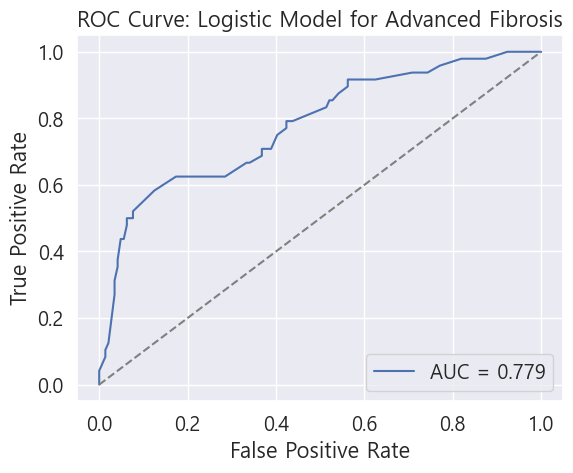

In [246]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve: Logistic Model for {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df["Adv_Fib_q_scoring"] = (
    -3 * df["PLT_qgroup"]
    - 2 * df["SMA (Volume)_qgroup"]
    + 2 * df["PT INR_qgroup"]
    + 2 * df["당뇨병/당뇨병 전단계 유무"]
)

In [ ]:
df["Adv_Fib_q_scoring"] = (
    -3 * df["PLT_qgroup"]
    - 2 * df["SMA (Volume)_qgroup"]
    + 2 * df["당뇨병/당뇨병 전단계 유무"]
)

In [ ]:
variables = ["PLT", "SMA (Volume)", "Age"]

cutoff_summary = pd.DataFrame(
    {
        "Variable": variables,
        "25% Quantile": [df[var].quantile(0.25) for var in variables],
        "75% Quantile": [df[var].quantile(0.75) for var in variables],
        "Unique Values": [df[var].dropna().unique() for var in variables],
    }
)

cutoff_summary

,Variable,25% Quantile,75% Quantile,Unique Values
0,PLT,176.750000,287.250000,"[285.0, 104.0, 297.0, 77.0, 151.0, 240.0, 159...."
1,SMA (Volume),766.432516,1219.868906,"[587.122687, 562.161625, 527.268063, 2985.2432..."
2,Age,38.750000,62.000000,"[65, 51, 71, 56, 69, 41, 50, 23, 55, 72, 47, 3..."


AUC: 0.780
Optimal cutoff: 2.00


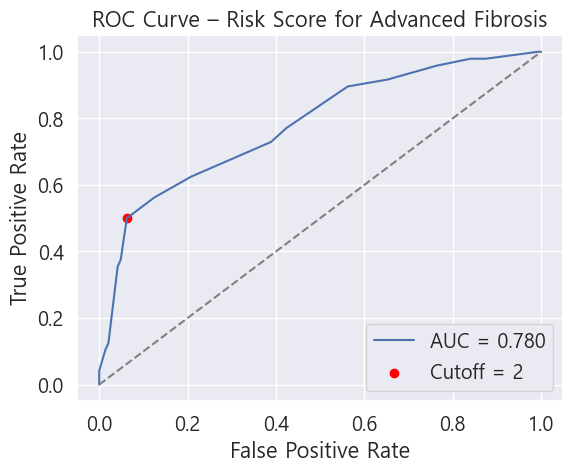

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC & AUC
y_true = df["Advanced Fibrosis"]
y_score = df["Adv_Fib_q_scoring"]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.3f}")

# Optimal cutoff: Youden's J
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal cutoff: {optimal_threshold:.2f}")

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[youden_idx],
    tpr[youden_idx],
    color="red",
    label=f"Cutoff = {optimal_threshold:.0f}",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Risk Score for Advanced Fibrosis")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Stratify into Low / Intermediate / High risk based on percentiles
df["RiskGroup"] = pd.qcut(
    df["Adv_Fib_q_scoring"], q=3, labels=["Low", "Intermediate", "High"]
)

# Optional: show distribution
print(df["RiskGroup"].value_counts())

RiskGroup
Low             68
Intermediate    64
High            60
Name: count, dtype: int64


In [ ]:
risk_summary = df.groupby("RiskGroup")["Advanced Fibrosis"].agg(
    ["count", "sum", "mean"]
)
risk_summary.rename(columns={"sum": "Events", "mean": "Event Rate"}, inplace=True)
print(risk_summary)

              count  Events  Event Rate
RiskGroup                              
Low              68       5    0.073529
Intermediate     64      13    0.203125
High             60      30    0.500000


C:\Users\chona\AppData\Local\Temp\ipykernel_3352\2431532262.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = df.groupby("RiskGroup")["Advanced Fibrosis"].agg(["count", "sum", "mean"])


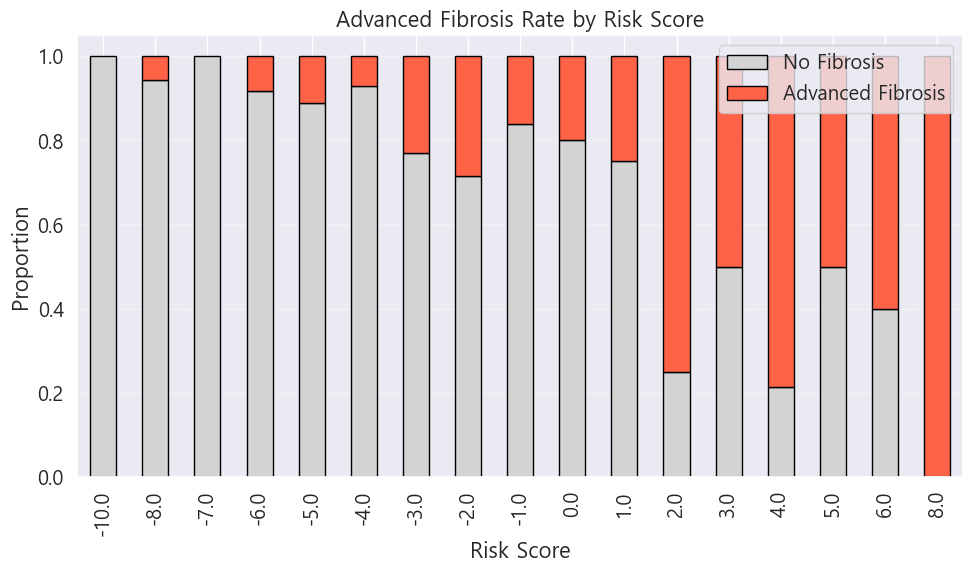

In [ ]:
import matplotlib.pyplot as plt

# 점수별 분포 집계
score_dist = (
    df.groupby("Adv_Fib_q_scoring")["Advanced Fibrosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# column 이름 정리 (0=No Fibrosis, 1=Yes Fibrosis)
score_dist.columns = ["No Fibrosis", "Advanced Fibrosis"]

# 정수 점수 순서대로 정렬
score_dist = score_dist.sort_index()

# 막대그래프
score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.ylabel("Proportion")
plt.xlabel("Risk Score")
plt.title("Advanced Fibrosis Rate by Risk Score")
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

Optimization terminated successfully.
         Current function value: 0.471506
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      Advanced Fibrosis   No. Observations:                  192
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                  0.1615
Time:                        22:59:21   Log-Likelihood:                -90.529
converged:                       True   LL-Null:                       -107.97
Covariance Type:            nonrobust   LLR p-value:                 1.293e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8631      0.677      2.752      0.006       0.536       3.190
당뇨병/당뇨병 전단계 유무   

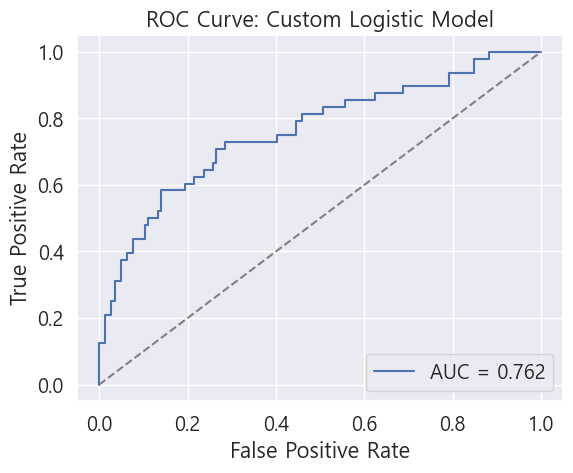

In [206]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. 사용할 변수 정의
fixed_vars = [
    "당뇨병/당뇨병 전단계 유무",
    # "Waist to Height",
    # "ALT",
    # "AST",
    "SMA (Volume)",
    "PLT",
]

df_model = df.copy()

# # 2. qgroup 인코딩
# for var in ["Waist to Height", "ALT", "AST", "SMA (Volume)"]:
#     q25 = df_model[var].quantile(0.25)
#     q75 = df_model[var].quantile(0.75)

#     def categorize_q(x):
#         if pd.isna(x):
#             return np.nan
#         elif x <= q25:
#             return 0
#         elif x <= q75:
#             return 1
#         else:
#             return 2

#     df_model[f"{var}_qgroup"] = df_model[var].apply(categorize_q)

# 3. 최종 모델 변수
# model_vars = ["당뇨병/당뇨병 전단계 유무"] + [f"{var}_qgroup" for var in ["Waist to Height", "ALT", "AST", "SMA (Volume)"]]
model_vars = fixed_vars
# 4. 결측 제거 + 정의
df_model_clean = df_model[[dependent_variable] + model_vars].dropna()
X = df_model_clean[model_vars]
y = df_model_clean[dependent_variable]
X = sm.add_constant(X)

# 5. 로지스틱 회귀
model = sm.Logit(y, X).fit()
print(model.summary())

# 6. 예측 + AUC
y_pred = model.predict(X)
auc = roc_auc_score(y, y_pred)
print(f"AUC: {auc:.3f}")

# 7. ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Custom Logistic Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [199]:
# Multivariate analysis for all groups
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming combined_data is already preprocessed and available

# Define continuous and categorical variables
continuous_vars = [
    "Age",
    "Weight",
    "Height",
    "Waist to Height",
    "Waist",
    "BMI",
    ##############################
    "FIB-4",
    "SBP",
    "DBP",
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    ############################
    "LSM",
    "CAP",
    ############################
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver/Spleen HU",
    "Liver (Volume)",
    "Spleen (Volume)",
    "Liver/Spleen Volume",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
]


# Convert continuous variables to binary (above/below median)
for var in continuous_vars:
    median_value = df[var].median()
    df[f"{var}_above_median"] = (df[var] > median_value).astype(int)

# List of categorical variables
categorical_vars = [
    "Sex",
    "Smoking",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]


# Define the list of covariates for the Cox model
covariates = [f"{var}_above_median" for var in continuous_vars] + [
    cat for cat in categorical_vars
]

In [171]:
covariates

['Age_above_median',
 'Weight_above_median',
 'Height_above_median',
 'Waist to Height_above_median',
 'Waist_above_median',
 'BMI_above_median',
 'FIB-4_above_median',
 'SBP_above_median',
 'DBP_above_median',
 'AST_above_median',
 'ALT_above_median',
 'T.bil_above_median',
 'PLT_above_median',
 'PT INR_above_median',
 'Alb_above_median',
 'Glucose_above_median',
 'HbA1c_above_median',
 'eGFR_above_median',
 'T.chol_above_median',
 'HDL_above_median',
 'LDL_above_median',
 'TG_above_median',
 'LSM_above_median',
 'CAP_above_median',
 'Liver (PDFF)_above_median',
 'Liver (HU)_above_median',
 'Spleen (HU)_above_median',
 'Liver/Spleen HU_above_median',
 'Liver (Volume)_above_median',
 'Spleen (Volume)_above_median',
 'Liver/Spleen Volume_above_median',
 'VFA (Volume)_above_median',
 'SFA (Volume)_above_median',
 'SMA (Volume)_above_median',
 'VFA (Area)_above_median',
 'SFA (Area)_above_median',
 'SMA (Area)_above_median',
 'VFA (Attenuation)_above_median',
 'SFA (Attenuation)_above_med

## Advanced Fibrosis에 대한 분석

In [95]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

dependent_variable = "Advanced Fibrosis"


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col=dependent_variable
)
odds_ratio_results

,Variable,OR,95% CI Lower,95% CI Upper,p-value
22,LSM_above_median,44.591837,10.386158,191.450186,3.252152e-07
6,FIB-4_above_median,6.614035,2.977692,14.691062,3.487864e-06
33,SMA (Volume)_above_median,0.151194,0.068069,0.335831,3.487864e-06
12,PLT_above_median,0.272978,0.133233,0.559299,3.885965e-04
43,SMI_above_median,0.272978,0.133233,0.559299,3.885965e-04
0,Age_above_median,3.663304,1.787954,7.505673,3.885965e-04
48,이상지질혈증 유무,3.370370,1.661457,6.837007,7.605727e-04
9,AST_above_median,3.304450,1.633213,6.685832,8.864856e-04
20,LDL_above_median,0.193798,0.072327,0.519278,1.102021e-03
2,Height_above_median,0.314286,0.153587,0.643124,1.533686e-03


In [172]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템에 따라 폰트 설정
if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif platform.system() == "Darwin":  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:
    plt.rcParams["font.family"] = "NanumGothic"

# 마이너 경고 제거 (음수 부호 깨짐 방지)
plt.rcParams["axes.unicode_minus"] = False

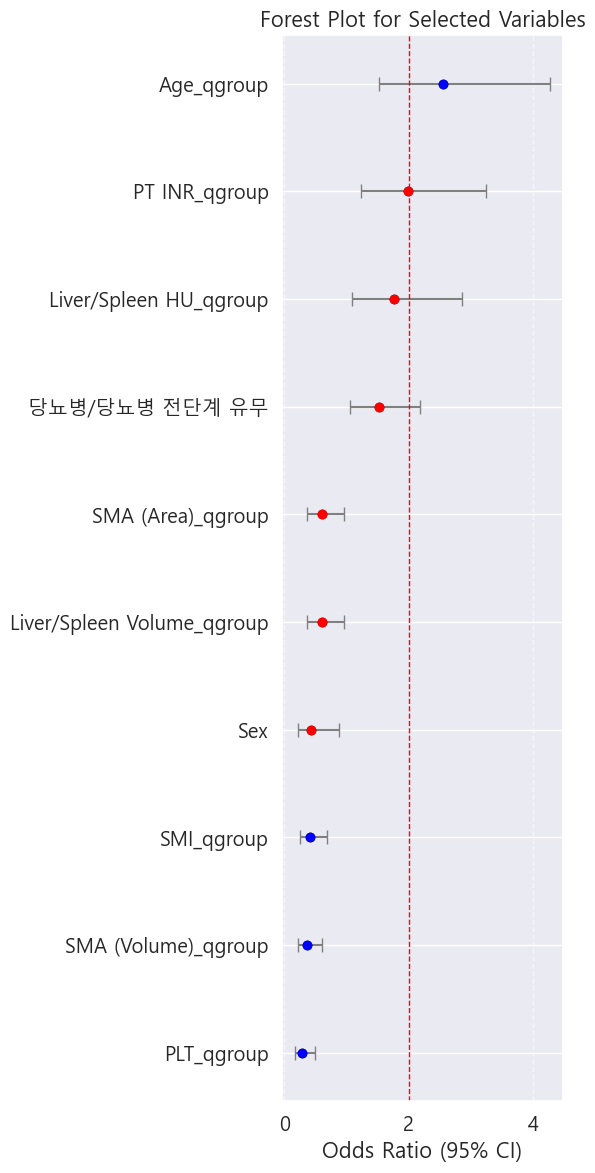

In [252]:
import matplotlib.pyplot as plt

# p < 0.05 + 높은 OR 순으로 상위 5개 자동 선택
sig_var_list = (
    odds_ratio_results[odds_ratio_results["p-value"] < 0.05]
    .sort_values("OR", ascending=False)
    .head(10)["Variable"]
    .tolist()
)

# "LSM_above_median" 제거
sig_var_list = [v for v in sig_var_list if v != "LSM_above_median"]

# 필터링된 결과
sig_df = odds_ratio_results[odds_ratio_results["Variable"].isin(sig_var_list)].copy()
sig_df.sort_values("OR", inplace=True)
y_pos = range(len(sig_df))

# 색 결정: p < 0.001 → blue, else red
colors = ["blue" if p < 0.001 else "red" for p in sig_df["p-value"]]

# Plot
plt.figure(figsize=(6, len(sig_df) * 1.2))
plt.errorbar(
    sig_df["OR"],
    y_pos,
    xerr=[sig_df["OR"] - sig_df["95% CI Lower"], sig_df["95% CI Upper"] - sig_df["OR"]],
    fmt="o",
    color="black",  # edge color
    ecolor="gray",
    capsize=5,
)

# scatter만 색 다르게
for i, (x, c) in enumerate(zip(sig_df["OR"], colors)):
    plt.scatter(x, i, color=c, zorder=3)

plt.axvline(x=2, color="red", linestyle="--", linewidth=1)
plt.yticks(y_pos, sig_df["Variable"])
plt.xlabel("Odds Ratio (95% CI)")
plt.title("Forest Plot for Selected Variables")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [258]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()
dependent_variable = "Advanced Fibrosis"


# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[[dependent_variable] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df[dependent_variable]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print(f"📊 Multivariable Logistic Regression for {dependent_variable}")

summary_df

📊 Multivariable Logistic Regression for Advanced Fibrosis


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.036519,0.237884,0.000013,0.355,0.223,0.565,0.64402
당뇨병/당뇨병 전단계 유무,0.486517,0.191229,0.010954,1.627,1.118,2.366,0.64402
Sex,-0.940940,0.370059,0.011001,0.390,0.189,0.806,0.64402


In [87]:
# AST열의 median
ast_median = df["AST"].median()
ast_median

np.float64(47.0)

In [ ]:
# AST_above_median열에 대해서만

In [ ]:
df["AST_above_median"] = (df["AST"] > 61).astype(int)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# Example placeholder: You should replace this with your actual DataFrame
# df = pd.read_csv("your_data.csv")  # <- load actual data if needed

# Placeholder variable names
categorical_vars = [
    "Sex",
    "Smoking",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "고혈압유무",
    "이상지질혈증 유무",
    "Ischemic Heart Diseae 유무",
    "Cerebrovascualr disease 유무",
    "Nephropathy 유무",
]

continuous_vars = [
    "Age",
    "Weight",
    "Height",
    "Waist to Height",
    "Waist",
    "BMI",
    "FIB-4",
    "SBP",
    "DBP",
    "AST",
    "ALT",
    "T.bil",
    "PLT",
    "PT INR",
    "Alb",
    "Glucose",
    "HbA1c",
    "eGFR",
    "T.chol",
    "HDL",
    "LDL",
    "TG",
    "LSM",
    "CAP",
    "Liver (PDFF)",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver/Spleen HU",
    "Liver (Volume)",
    "Spleen (Volume)",
    "Liver/Spleen Volume",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
]

# Make sure 'Advanced Fibrosis' column exists and is binary
target = "Advanced Fibrosis"

results = []

# Calculate AUC for continuous and categorical variables
for var in categorical_vars + continuous_vars:
    if var in df.columns:
        temp_df = df[[var, target]].dropna()
        if temp_df[target].nunique() < 2:
            continue
        try:
            auc = roc_auc_score(temp_df[target], temp_df[var])
            results.append(
                {
                    "Variable": var,
                    "Type": "Categorical" if var in categorical_vars else "Continuous",
                    "AUC": auc,
                }
            )
        except:
            continue

auc_df = (
    pd.DataFrame(results).sort_values(by="AUC", ascending=False).reset_index(drop=True)
)

auc_df

,Variable,Type,AUC
0,LSM,Continuous,0.910952
1,FIB-4,Continuous,0.759259
2,Age,Continuous,0.685909
3,PT INR,Continuous,0.648293
4,이상지질혈증 유무,Categorical,0.628472
5,AST,Continuous,0.615813
6,T.bil,Continuous,0.596861
7,당뇨병/당뇨병 전단계 유무2,Categorical,0.593750
8,Liver/Spleen HU,Continuous,0.593171
9,당뇨병/당뇨병 전단계 유무,Categorical,0.592448


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

dependent_variable = "Advanced Fibrosis"

from sklearn.metrics import roc_auc_score


def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])
            pval = model.pvalues[var]

            # AUC 계산
            y_pred = model.predict(sub_df[["const", var]])
            auc = roc_auc_score(sub_df[outcome_col], y_pred)

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                    "AUC": auc,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col=dependent_variable
)
odds_ratio_results

,Variable,OR,95% CI Lower,95% CI Upper,p-value,AUC
22,LSM_above_median,44.591837,10.386158,191.450186,3.252152e-07,0.809028
6,FIB-4_above_median,6.614035,2.977692,14.691062,3.487864e-06,0.708333
33,SMA (Volume)_above_median,0.151194,0.068069,0.335831,3.487864e-06,0.708333
12,PLT_above_median,0.272978,0.133233,0.559299,3.885965e-04,0.652778
43,SMI_above_median,0.272978,0.133233,0.559299,3.885965e-04,0.652778
0,Age_above_median,3.663304,1.787954,7.505673,3.885965e-04,0.652778
49,이상지질혈증 유무,3.370370,1.661457,6.837007,7.605727e-04,0.625000
9,AST_above_median,3.304450,1.633213,6.685832,8.864856e-04,0.642361
20,LDL_above_median,0.193798,0.072327,0.519278,1.102021e-03,0.635417
2,Height_above_median,0.314286,0.153587,0.643124,1.533686e-03,0.635417


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    # "Spleen (Volume)",
    # "Liver (Volume)",
    # "VFA (Area)",
    # "SFA (Area)",
    # "SMA (Area)",
    # "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    # "Liver (HU)",
    # "Spleen (HU)",
    # "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]


significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
)

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)


# Exclude LSM from modeling
significant_vars = [
    var
    for var in significant_vars
    if var != "LSM_above_median" and var != "FIB-4_above_median"
]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[[dependent_variable] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df[dependent_variable]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print(f"📊 Multivariable Logistic Regression for {dependent_variable}")

summary_df

📊 Multivariable Logistic Regression for Advanced Fibrosis


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.561003,0.418382,0.000191,0.210,0.092,0.477,0.84049
당뇨병/당뇨병 전단계 유무2,0.940437,0.433008,0.029866,2.561,1.096,5.984,0.84049
Waist to Height_above_median,0.865743,0.422376,0.040394,2.377,1.039,5.439,0.84049
SMA (Volume)_above_median,-2.073661,0.464714,0.000008,0.126,0.051,0.313,0.84049
ALT_above_median,-1.243339,0.476621,0.009090,0.288,0.113,0.734,0.84049
AST_above_median,1.862972,0.492773,0.000156,6.443,2.453,16.925,0.84049


✅ Multivariable Model AUC: 0.840 (95% CI: 0.767 – 0.900)
✅ LSM only AUC: 0.913
✅ FIB-4 only AUC: 0.758


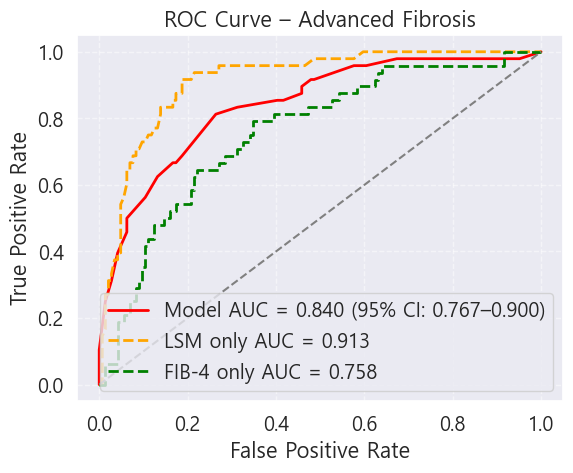

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ──────────────── ROC & AUC: 모델 ────────────────
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# ──────────────── ROC & AUC: LSM ────────────────
df_lsm = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_lsm[dependent_variable]
x_lsm = df_lsm["LSM"]
auc_lsm = roc_auc_score(y_lsm, x_lsm)
fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)

# ──────────────── ROC & AUC: FIB-4 ────────────────
df_fib = df[[dependent_variable, "FIB-4"]].dropna()
y_fib = df_fib[dependent_variable]
x_fib = df_fib["FIB-4"]
auc_fib = roc_auc_score(y_fib, x_fib)
fpr_fib, tpr_fib, _ = roc_curve(y_fib, x_fib)

# ──────────────── Bootstrap CI (Model) ────────────────
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# ──────────────── Print AUC info ────────────────
print(
    f"✅ Multivariable Model AUC: {auc_model:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})"
)
print(f"✅ LSM only AUC: {auc_lsm:.3f}")
print(f"✅ FIB-4 only AUC: {auc_fib:.3f}")

# ──────────────── Plot ROC Curve ────────────────
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_model,
    tpr_model,
    label=f"Model AUC = {auc_model:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})",
    lw=2,
    color="red",
)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    linestyle="--",
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    color="orange",
)
plt.plot(
    fpr_fib,
    tpr_fib,
    linestyle="--",
    label=f"FIB-4 only AUC = {auc_fib:.3f}",
    lw=2,
    color="green",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df["Advanced_Fibrosis_risk_score"] = (
    +3 * df["AST_above_median"]
    + 2 * df["당뇨병/당뇨병 전단계 유무2"]
    + 2 * df["Waist to Height_above_median"]
    - 3 * df["SMA (Volume)_above_median"]
    - 2 * df["ALT_above_median"]
)

In [ ]:
df["Advanced_Fibrosis_risk_score"].

✅ Scoring AUC: 0.832
✅ Multivariable Model AUC: 0.840
✅ LSM only AUC: 0.913


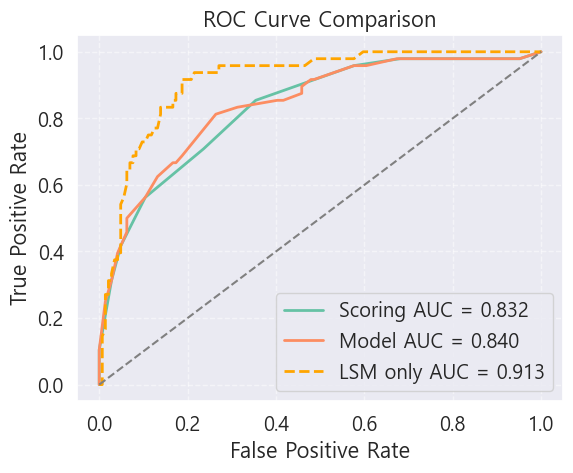

In [182]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ▶ 1. Scoring 기반 예측값
score = df["Advanced_Fibrosis_risk_score"]
y_true = df["Advanced Fibrosis"]

# ▶ 2. Multivariable 모델 예측값 (← 반드시 이걸로)
y_pred = final_model.predict(X[final_vars])

# ▶ 3. LSM 예측값
df_lsm = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_lsm[dependent_variable]
x_lsm = df_lsm["LSM"]

# ▶ ROC 계산
fpr_score, tpr_score, _ = roc_curve(y_true, score)
auc_score = roc_auc_score(y_true, score)

fpr_model, tpr_model, _ = roc_curve(y, y_pred)
auc_model = roc_auc_score(y, y_pred)

fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)
auc_lsm = roc_auc_score(y_lsm, x_lsm)

# ▶ AUC 출력
print(f"✅ Scoring AUC: {auc_score:.3f}")
print(f"✅ Multivariable Model AUC: {auc_model:.3f}")
print(f"✅ LSM only AUC: {auc_lsm:.3f}")

# ▶ Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_score, tpr_score, label=f"Scoring AUC = {auc_score:.3f}", lw=2)
plt.plot(fpr_model, tpr_model, label=f"Model AUC = {auc_model:.3f}", lw=2)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    linestyle="--",
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    color="orange",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

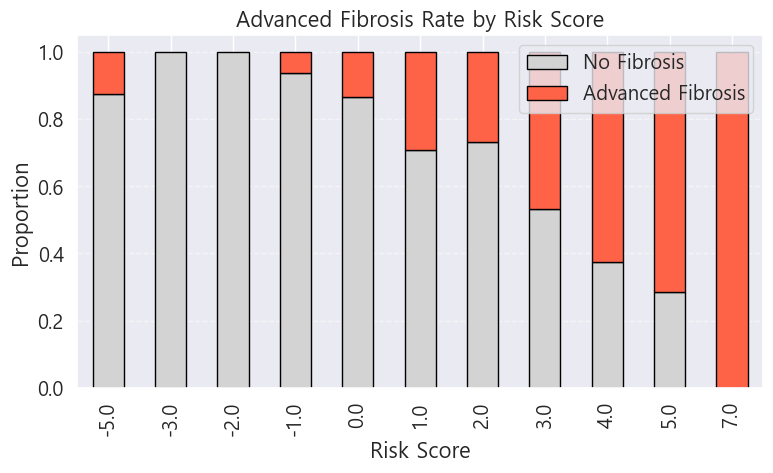

In [183]:
import matplotlib.pyplot as plt

score_dist = (
    df.groupby("Advanced_Fibrosis_risk_score")["Advanced Fibrosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .rename(columns={0: "No Fibrosis", 1: "Advanced Fibrosis"})
    .sort_index()
)

score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.xlabel("Risk Score")
plt.ylabel("Proportion")
plt.title("Advanced Fibrosis Rate by Risk Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

C:\Users\chona\AppData\Local\Temp\ipykernel_12368\3001712904.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("RiskScore_Binned")["Advanced Fibrosis"]


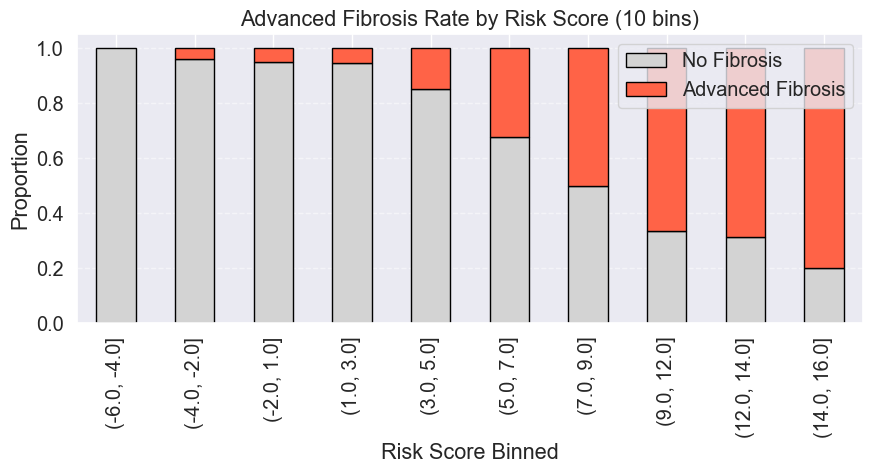

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 10개 bin으로 자르기 (등간격)
df["RiskScore_Binned"] = pd.cut(
    df["Advanced_Fibrosis_risk_score"], bins=10, precision=0
)

# 비율 계산
score_dist = (
    df.groupby("RiskScore_Binned")["Advanced Fibrosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .rename(columns={0: "No Fibrosis", 1: "Advanced Fibrosis"})
)

# 시각화
score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.xlabel("Risk Score Binned")
plt.ylabel("Proportion")
plt.title("Advanced Fibrosis Rate by Risk Score (10 bins)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

✅ Scoring AUC: 0.845
✅ Multivariable Model AUC: 0.850
✅ LSM only AUC: 0.911


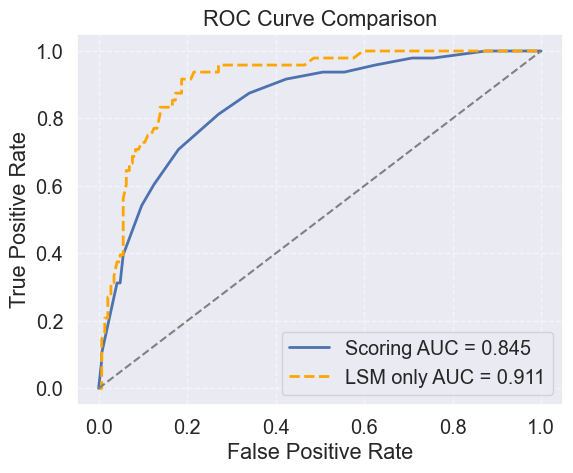

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# ▶ 1. Scoring 기반 예측값
score = df["Advanced_Fibrosis_risk_score"]
y_true = df["Advanced Fibrosis"]

# ▶ 2. Multivariable 모델 예측값 (y_pred)
# 가정: y_pred는 이미 예측 확률로 계산되어 있음

# ▶ 3. LSM 예측값
df_lsm = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_lsm[dependent_variable]
x_lsm = df_lsm["LSM"]

# ▶ ROC 계산
fpr_score, tpr_score, _ = roc_curve(y_true, score)
auc_score = roc_auc_score(y_true, score)

fpr_model, tpr_model, _ = roc_curve(y_true, y_pred)
auc_model = roc_auc_score(y_true, y_pred)

fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)
auc_lsm = roc_auc_score(y_lsm, x_lsm)

# ▶ AUC 출력
print(f"✅ Scoring AUC: {auc_score:.3f}")
print(f"✅ Multivariable Model AUC: {auc_model:.3f}")
print(f"✅ LSM only AUC: {auc_lsm:.3f}")

# ▶ Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_score, tpr_score, label=f"Scoring AUC = {auc_score:.3f}", lw=2)
plt.plot(fpr_model, tpr_model, label=f"Model AUC = {auc_model:.3f}", lw=2)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    linestyle="--",
    color="orange",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

✅ Multivariable Model AUC: 0.840 (95% CI: 0.767 – 0.900)
✅ LSM only AUC: 0.913
✅ FIB-4 only AUC: 0.758


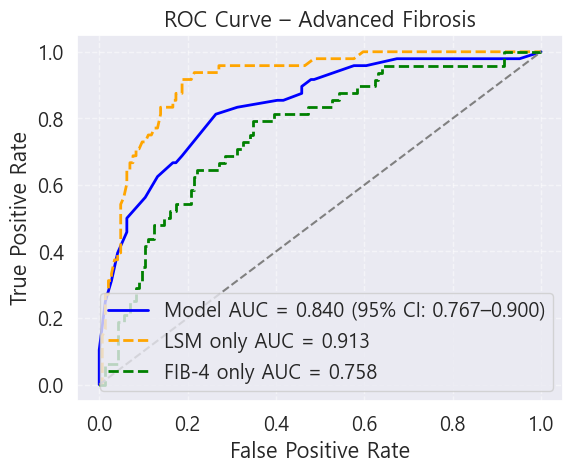

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ──────────────── ROC & AUC: 모델 ────────────────
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# ──────────────── ROC & AUC: LSM ────────────────
df_lsm = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_lsm[dependent_variable]
x_lsm = df_lsm["LSM"]
auc_lsm = roc_auc_score(y_lsm, x_lsm)
fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)

# ──────────────── ROC & AUC: FIB-4 ────────────────
df_fib = df[[dependent_variable, "FIB-4"]].dropna()
y_fib = df_fib[dependent_variable]
x_fib = df_fib["FIB-4"]
auc_fib = roc_auc_score(y_fib, x_fib)
fpr_fib, tpr_fib, _ = roc_curve(y_fib, x_fib)

# ──────────────── Bootstrap CI (Model) ────────────────
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# ──────────────── Print AUC info ────────────────
print(
    f"✅ Multivariable Model AUC: {auc_model:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})"
)
print(f"✅ LSM only AUC: {auc_lsm:.3f}")
print(f"✅ FIB-4 only AUC: {auc_fib:.3f}")

# ──────────────── Plot ROC Curve ────────────────
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_model,
    tpr_model,
    label=f"Model AUC = {auc_model:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})",
    lw=2,
    color="blue",
)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    linestyle="--",
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    color="orange",
)
plt.plot(
    fpr_fib,
    tpr_fib,
    linestyle="--",
    label=f"FIB-4 only AUC = {auc_fib:.3f}",
    lw=2,
    color="green",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df["Adv_Fib_RiskScore"] = (
    +5 * df["AST_above_median"]
    + 4 * df["PT INR_above_median"]
    + 3 * df["당뇨병/당뇨병 전단계 유무"]
    - 3 * df["SMA (Area)_above_median"]
    - 5 * df["SMA (Volume)_above_median"]
)

In [ ]:
df["Adv_Fib_RiskScore"] = (
    5 * df["AST_above_median"]
    + 2 * df["Waist to Height_above_median"]
    + 1 * df["당뇨병/당뇨병 전단계 유무"]
    - 3 * df["ALT_above_median"]
    - 5 * df["SMA (Volume)_above_median"]
)

AUC: 0.851
Optimal cutoff: 4.00


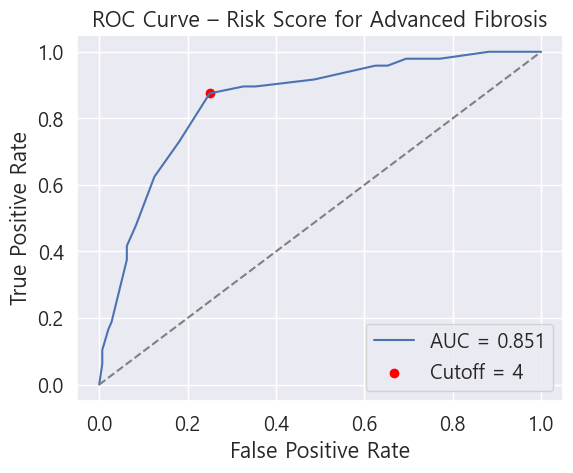

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC & AUC
y_true = df["Advanced Fibrosis"]
y_score = df["Adv_Fib_RiskScore"]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.3f}")

# Optimal cutoff: Youden's J
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal cutoff: {optimal_threshold:.2f}")

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[youden_idx],
    tpr[youden_idx],
    color="red",
    label=f"Cutoff = {optimal_threshold:.0f}",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Risk Score for Advanced Fibrosis")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Stratify into Low / Intermediate / High risk based on percentiles
df["RiskGroup"] = pd.qcut(
    df["Adv_Fib_RiskScore"], q=3, labels=["Low", "Intermediate", "High"]
)

# Optional: show distribution
print(df["RiskGroup"].value_counts())

RiskGroup
Low             78
High            61
Intermediate    53
Name: count, dtype: int64


In [ ]:
risk_summary = df.groupby("RiskGroup")["Advanced Fibrosis"].agg(
    ["count", "sum", "mean"]
)
risk_summary.rename(columns={"sum": "Events", "mean": "Event Rate"}, inplace=True)
print(risk_summary)

              count  Events  Event Rate
RiskGroup                              
Low              78       4    0.051282
Intermediate     53       9    0.169811
High             61      35    0.573770


C:\Users\chona\AppData\Local\Temp\ipykernel_3352\2431532262.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = df.groupby("RiskGroup")["Advanced Fibrosis"].agg(["count", "sum", "mean"])


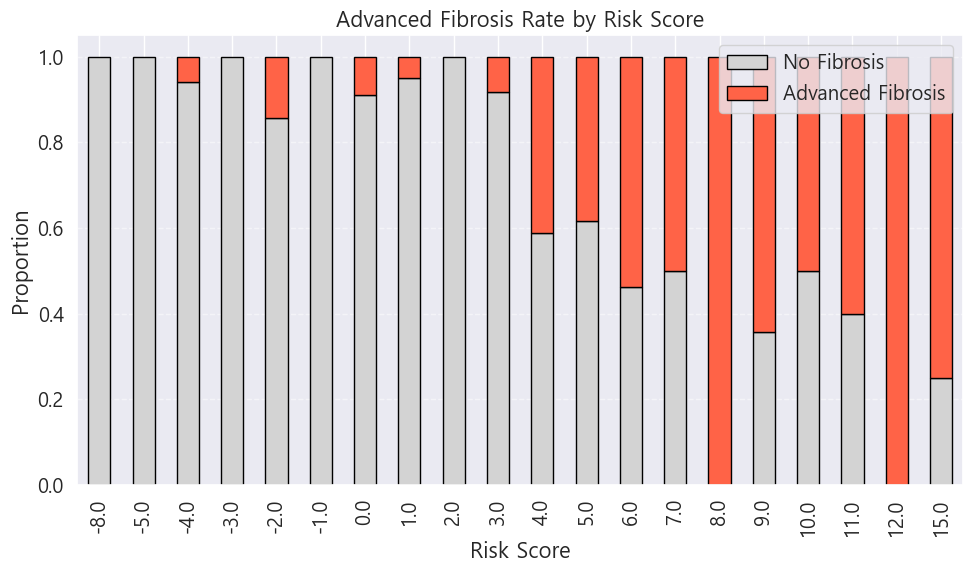

In [ ]:
import matplotlib.pyplot as plt

# 점수별 분포 집계
score_dist = (
    df.groupby("Adv_Fib_RiskScore")["Advanced Fibrosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# column 이름 정리 (0=No Fibrosis, 1=Yes Fibrosis)
score_dist.columns = ["No Fibrosis", "Advanced Fibrosis"]

# 정수 점수 순서대로 정렬
score_dist = score_dist.sort_index()

# 막대그래프
score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.ylabel("Proportion")
plt.xlabel("Risk Score")
plt.title("Advanced Fibrosis Rate by Risk Score")
plt.legend(loc="upper right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

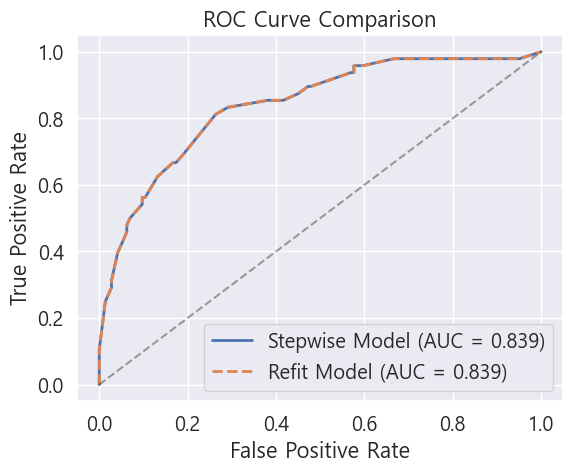

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# ──────────────────────────────────────────────
# 1. 최종 모델 ROC curve (이미 있음)
fpr1, tpr1, _ = roc_curve(y, y_pred)
auc1 = roc_auc_score(y, y_pred)

# ──────────────────────────────────────────────
# 2. 최종 변수로 새로 만든 모델
X_new = model_df[final_vars[1:]]  # same vars as stepwise
X_new = sm.add_constant(X_new)
new_model = sm.Logit(y, X_new).fit(disp=0)
y_pred_new = new_model.predict(X_new)
fpr2, tpr2, _ = roc_curve(y, y_pred_new)
auc2 = roc_auc_score(y, y_pred_new)

# ──────────────────────────────────────────────
# 3. 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, label=f"Stepwise Model (AUC = {auc1:.3f})", lw=2)
plt.plot(fpr2, tpr2, label=f"Refit Model (AUC = {auc2:.3f})", lw=2, linestyle="--")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

dependent_variable = "Significant Fibrosis"


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col=dependent_variable
)
# print(odds_ratio_results)

import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()


# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    # "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[[dependent_variable] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df[dependent_variable]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print(f"📊 Multivariable Logistic Regression for {dependent_variable}")

summary_df

📊 Multivariable Logistic Regression for Significant Fibrosis


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.885269,0.442969,0.000021,0.152,0.064,0.362,0.81516
Age_above_median,0.971063,0.376464,0.009896,2.641,1.263,5.523,0.81516
Waist to Height_above_median,0.753780,0.375684,0.044812,2.125,1.018,4.438,0.81516
SMA (Volume)_above_median,-1.436701,0.397925,0.000306,0.238,0.109,0.519,0.81516
당뇨병/당뇨병 전단계 유무,0.549385,0.206991,0.007951,1.732,1.155,2.599,0.81516
AST_above_median,1.365009,0.368145,0.000209,3.916,1.903,8.057,0.81516


✅ Multivariable Model AUC: 0.815 (95% CI: 0.744 – 0.872)
✅ LSM only AUC: 0.883
✅ FIB-4 only AUC: 0.746


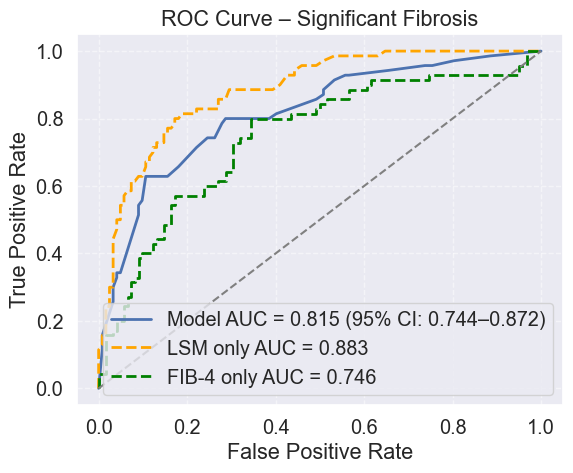

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ──────────────── ROC & AUC: 모델 ────────────────
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# ──────────────── ROC & AUC: LSM ────────────────
df_lsm = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_lsm[dependent_variable]
x_lsm = df_lsm["LSM"]
auc_lsm = roc_auc_score(y_lsm, x_lsm)
fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)

# ──────────────── ROC & AUC: FIB-4 ────────────────
df_fib = df[[dependent_variable, "FIB-4"]].dropna()
y_fib = df_fib[dependent_variable]
x_fib = df_fib["FIB-4"]
auc_fib = roc_auc_score(y_fib, x_fib)
fpr_fib, tpr_fib, _ = roc_curve(y_fib, x_fib)

# ──────────────── Bootstrap CI (Model) ────────────────
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# ──────────────── Print AUC info ────────────────
print(
    f"✅ Multivariable Model AUC: {auc_model:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})"
)
print(f"✅ LSM only AUC: {auc_lsm:.3f}")
print(f"✅ FIB-4 only AUC: {auc_fib:.3f}")

# ──────────────── Plot ROC Curve ────────────────
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_model,
    tpr_model,
    label=f"Model AUC = {auc_model:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})",
    lw=2,
)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    linestyle="--",
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    color="orange",
)
plt.plot(
    fpr_fib,
    tpr_fib,
    linestyle="--",
    label=f"FIB-4 only AUC = {auc_fib:.3f}",
    lw=2,
    color="green",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

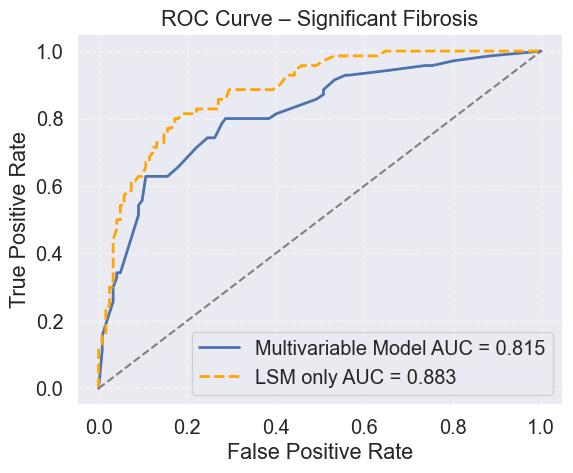

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 기존 모델 ROC
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# LSM 단일 변수 ROC
df_valid = df[[dependent_variable, "LSM"]].dropna()
y_lsm = df_valid[dependent_variable]
x_lsm = df_valid["LSM"]

auc_lsm = roc_auc_score(y_lsm, x_lsm)
fpr_lsm, tpr_lsm, _ = roc_curve(y_lsm, x_lsm)

# 모델의 bootstrap AUC CI
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_model, tpr_model, label=f"Multivariable Model AUC = {auc_model:.3f}", lw=2)
plt.plot(
    fpr_lsm,
    tpr_lsm,
    linestyle="--",
    label=f"LSM only AUC = {auc_lsm:.3f}",
    lw=2,
    color="orange",
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

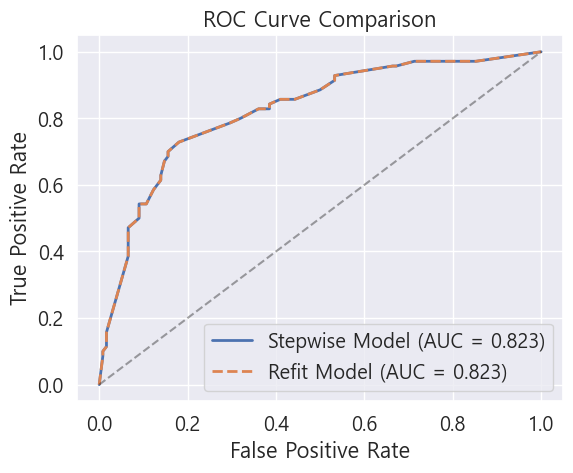

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# ──────────────────────────────────────────────
# 1. 최종 모델 ROC curve (이미 있음)
fpr1, tpr1, _ = roc_curve(y, y_pred)
auc1 = roc_auc_score(y, y_pred)

# ──────────────────────────────────────────────
# 2. 최종 변수로 새로 만든 모델
X_new = model_df[final_vars[1:]]  # same vars as stepwise
X_new = sm.add_constant(X_new)
new_model = sm.Logit(y, X_new).fit(disp=0)
y_pred_new = new_model.predict(X_new)
fpr2, tpr2, _ = roc_curve(y, y_pred_new)
auc2 = roc_auc_score(y, y_pred_new)

# ──────────────────────────────────────────────
# 3. 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, label=f"Stepwise Model (AUC = {auc1:.3f})", lw=2)
plt.plot(fpr2, tpr2, label=f"Refit Model (AUC = {auc2:.3f})", lw=2, linestyle="--")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [188]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

dependent_variable = "Severe Steatosis"


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col=dependent_variable
)
# print(odds_ratio_results)

import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    # "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    # "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    # "Liver (HU)",
    # "Spleen (HU)",
    # "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[[dependent_variable] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df[dependent_variable]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print(f"📊 Multivariable Logistic Regression for {dependent_variable}")

summary_df

📊 Multivariable Logistic Regression for Severe Steatosis


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.110422,0.473509,0.019022,0.329,0.130,0.833,0.84666
Sex,1.162950,0.420384,0.005668,3.199,1.404,7.293,0.84666
TFI_above_median,1.101557,0.412948,0.007641,3.009,1.339,6.759,0.84666
Liver (Volume)_above_median,1.043141,0.396320,0.008487,2.838,1.305,6.171,0.84666
PT INR_above_median,-0.910942,0.390738,0.019736,0.402,0.187,0.865,0.84666
Liver/Spleen HU_above_median,-1.830665,0.398526,0.000004,0.160,0.073,0.350,0.84666


In [ ]:
df["Severe_Steatosis_risk_score"] = (
    +2 * df["Sex"]
    + 2 * df["TFI_above_median"]
    + 2 * df["Liver (Volume)_above_median"]
    - 2 * df["PT INR_above_median"]
    - 3 * df["Liver/Spleen HU_above_median"]
)

In [193]:
df["Severe_Steatosis_risk_score"].unique()

array([-5, -3, -1,  4,  2,  6, -2,  0,  1,  3])

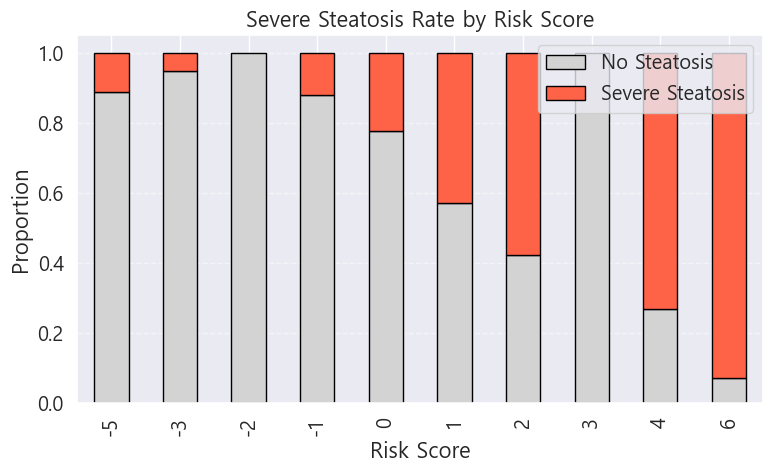

In [192]:
import matplotlib.pyplot as plt

# 점수별 비율 집계
score_dist = (
    df.groupby("Severe_Steatosis_risk_score")["Severe Steatosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
score_dist.columns = ["No Steatosis", "Severe Steatosis"]
score_dist = score_dist.sort_index()

# 막대그래프
score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.xlabel("Risk Score")
plt.ylabel("Proportion")
plt.title("Severe Steatosis Rate by Risk Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

C:\Users\chona\AppData\Local\Temp\ipykernel_12368\279941044.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Severe_Steatosis_Binned")["Severe Steatosis"]


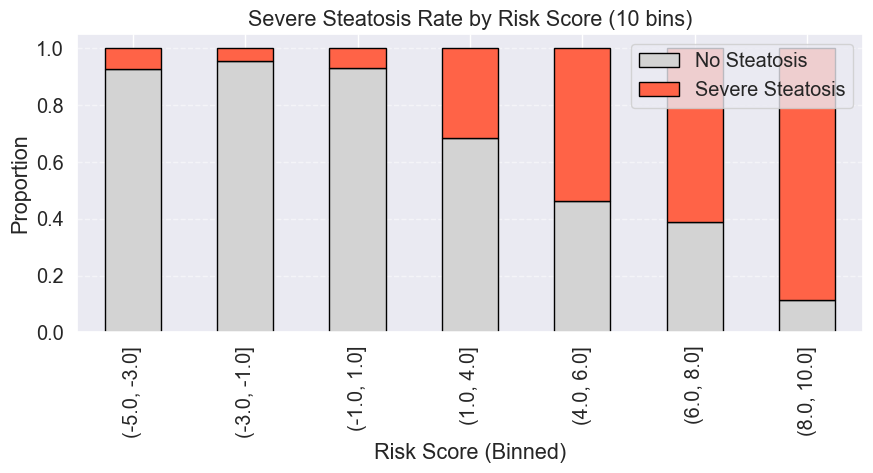

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 점수 binning (10개 구간)
df["Severe_Steatosis_Binned"] = pd.cut(
    df["Severe_Steatosis_risk_score"], bins=7, precision=0
)

# 비율 계산
score_dist = (
    df.groupby("Severe_Steatosis_Binned")["Severe Steatosis"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .rename(columns={0: "No Steatosis", 1: "Severe Steatosis"})
)

# 시각화
score_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=["lightgray", "tomato"],
    edgecolor="black",
)

plt.xlabel("Risk Score (Binned)")
plt.ylabel("Proportion")
plt.title("Severe Steatosis Rate by Risk Score (10 bins)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

✅ Multivariable Model AUC: 0.847 (95% CI: 0.786 – 0.901)
✅ CAP only AUC: 0.728


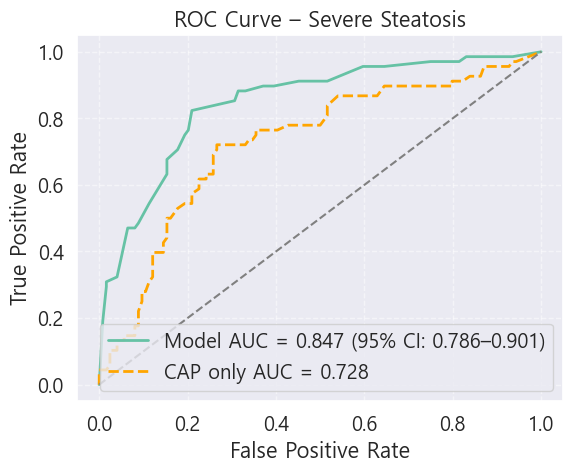

In [194]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 기존 모델 ROC
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# CAP 단일 변수 ROC
df_cap = df[[dependent_variable, "CAP"]].dropna()
y_cap = df_cap[dependent_variable]
x_cap = df_cap["CAP"]
auc_cap = roc_auc_score(y_cap, x_cap)
fpr_cap, tpr_cap, _ = roc_curve(y_cap, x_cap)

# 모델 bootstrap AUC CI
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# ▶ AUC + CI 출력
print(
    f"✅ Multivariable Model AUC: {auc_model:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})"
)
print(f"✅ CAP only AUC: {auc_cap:.3f}")

# ▶ Plot
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_model,
    tpr_model,
    label=f"Model AUC = {auc_model:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})",
    lw=2,
)
plt.plot(
    fpr_cap,
    tpr_cap,
    linestyle="--",
    label=f"CAP only AUC = {auc_cap:.3f}",
    lw=2,
    color="orange",
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

dependent_variable = "Mild Steatosis"


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col=dependent_variable
)
# print(odds_ratio_results)

import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[[dependent_variable] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df[dependent_variable]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print(f"📊 Multivariable Logistic Regression for {dependent_variable}")

summary_df

📊 Multivariable Logistic Regression for Mild Steatosis


c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\chona\AppData\Local\Temp\ipykernel_12368\176908355.py:28: RuntimeWarning: overflow encountered in exp
  ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,2.680181,0.748033,0.000340,14.588,3.367,63.201,0.84171
Alb_above_median,1.718702,0.785679,0.028703,5.577,1.196,26.014,0.84171
Waist to Height_above_median,1.635433,0.600120,0.006427,5.132,1.583,16.638,0.84171
Liver/Spleen HU_above_median,-2.207786,0.774837,0.004381,0.110,0.024,0.502,0.84171


✅ Multivariable Model AUC: 0.842 (95% CI: 0.774 – 0.897)
✅ CAP only AUC: 0.744


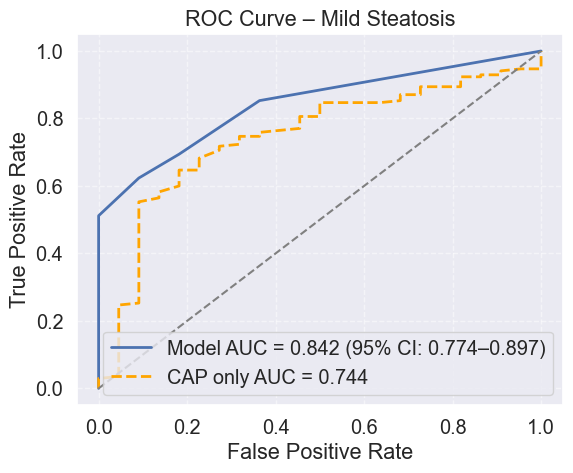

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 기존 모델 ROC
auc_model = roc_auc_score(y, y_pred)
fpr_model, tpr_model, _ = roc_curve(y, y_pred)

# CAP 단일 변수 ROC
df_cap = df[[dependent_variable, "CAP"]].dropna()
y_cap = df_cap[dependent_variable]
x_cap = df_cap["CAP"]
auc_cap = roc_auc_score(y_cap, x_cap)
fpr_cap, tpr_cap, _ = roc_curve(y_cap, x_cap)

# 모델 bootstrap AUC CI
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)
bootstrapped_aucs = []

for _ in range(n_bootstraps):
    indices = rng.choice(len(y), size=len(y), replace=True)
    if len(np.unique(y.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y.iloc[indices], y_pred.iloc[indices])
    bootstrapped_aucs.append(score)

ci_lower = np.percentile(bootstrapped_aucs, 2.5)
ci_upper = np.percentile(bootstrapped_aucs, 97.5)

# ▶ AUC + CI 출력
print(
    f"✅ Multivariable Model AUC: {auc_model:.3f} (95% CI: {ci_lower:.3f} – {ci_upper:.3f})"
)
print(f"✅ CAP only AUC: {auc_cap:.3f}")

# ▶ Plot
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_model,
    tpr_model,
    label=f"Model AUC = {auc_model:.3f} (95% CI: {ci_lower:.3f}–{ci_upper:.3f})",
    lw=2,
)
plt.plot(
    fpr_cap,
    tpr_cap,
    linestyle="--",
    label=f"CAP only AUC = {auc_cap:.3f}",
    lw=2,
    color="orange",
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {dependent_variable}")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

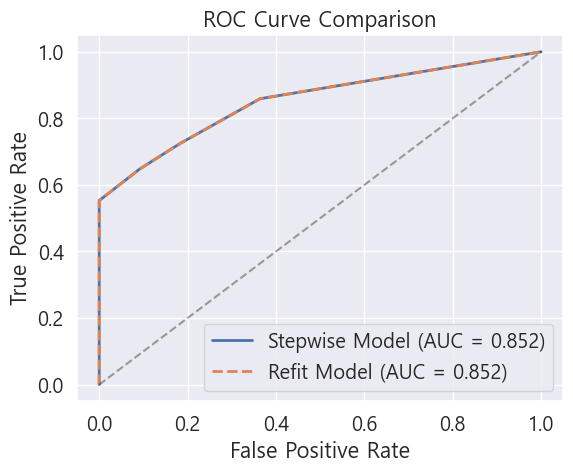

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# ──────────────────────────────────────────────
# 1. 최종 모델 ROC curve (이미 있음)
fpr1, tpr1, _ = roc_curve(y, y_pred)
auc1 = roc_auc_score(y, y_pred)

# ──────────────────────────────────────────────
# 2. 최종 변수로 새로 만든 모델
X_new = model_df[final_vars[1:]]  # same vars as stepwise
X_new = sm.add_constant(X_new)
new_model = sm.Logit(y, X_new).fit(disp=0)
y_pred_new = new_model.predict(X_new)
fpr2, tpr2, _ = roc_curve(y, y_pred_new)
auc2 = roc_auc_score(y, y_pred_new)

# ──────────────────────────────────────────────
# 3. 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, label=f"Stepwise Model (AUC = {auc1:.3f})", lw=2)
plt.plot(fpr2, tpr2, label=f"Refit Model (AUC = {auc2:.3f})", lw=2, linestyle="--")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [341]:
df_model = df.copy()

model_df = df_model[[outcome_var] + final_vars[1:]].dropna()

In [ ]:
df["당뇨병/당뇨병 전단계 유무"] = df["당뇨병/당뇨병 전단계 유무"].astype("int64")

In [ ]:
print(X.dtypes)

SMA (Volume)_above_median       int64
AST_above_median                int64
Waist to Height_above_median    int64
ALT_above_median                int64
당뇨병/당뇨병 전단계 유무                  Int64
dtype: object


AUC: 0.839
Best Cutoff: 0.286 | Sensitivity: 0.812 | Specificity: 0.736


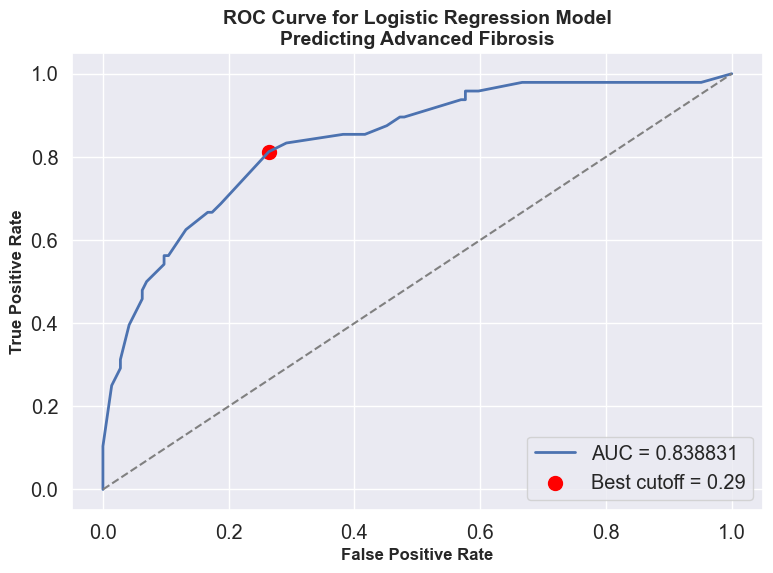

In [349]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data
df_model = df.copy()
# df_model["Moderate Steatosis"] = (
#     df_model["Steatosis Score"].isin(
#         [
#             # 1,
#             2,
#             3,
#         ]
#     )
# ).astype(int)

# Define final variables

outcome_var = "Advanced Fibrosis"

# Drop NA
model_df = df_model[[outcome_var] + final_vars[1:]].dropna()
X = model_df[final_vars[1:]]
y = model_df[outcome_var]

# Add constant
X_const = sm.add_constant(X)

# Fit logistic regression model
final_model = sm.Logit(y, X_const).fit(disp=0)

# Predict probabilities on full data
y_prob = final_model.predict(X_const)
y_true = y.values

# AUC and ROC
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print metrics
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.6f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)
plt.title(
    f"ROC Curve for Logistic Regression Model\nPredicting {outcome_var}",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_LogReg_FullData.png", dpi=600, bbox_inches="tight")
plt.show()

## Significant Fibrosis에 대한 분석

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col="Significant Fibrosis"
)
odds_ratio_results

,Variable,OR,95% CI Lower,95% CI Upper,p-value
22,LSM_above_median,14.914286,6.864621,32.403234,8.740011e-12
6,FIB-4_above_median,5.727770,2.958589,11.088852,2.240636e-07
0,Age_above_median,4.130435,2.189325,7.792581,1.190218e-05
33,SMA (Volume)_above_median,0.242105,0.128327,0.456762,1.190218e-05
20,LDL_above_median,0.212459,0.096675,0.466912,1.153697e-04
9,AST_above_median,3.150362,1.699803,5.838783,2.672067e-04
2,Height_above_median,0.318367,0.170485,0.594527,3.284445e-04
36,SMA (Area)_above_median,0.328476,0.177364,0.608332,3.989902e-04
12,PLT_above_median,0.362319,0.196600,0.667726,1.134846e-03
46,당뇨병/당뇨병 전단계 유무,1.702037,1.201453,2.411189,2.764697e-03


In [283]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()


# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    # "VFI",
    # "SFI",
    # "TFI",
    # "SMI",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    # "VFA (Area)",
    # "SFA (Area)",
    # "SMA (Area)",
    # "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Significant Fibrosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Significant Fibrosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print("📊 Multivariable Logistic Regression for Advanced Fibrosis (Fibrosis Stage 3-4)")

summary_df

📊 Multivariable Logistic Regression for Advanced Fibrosis (Fibrosis Stage 3-4)


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.933760,0.455654,0.000022,0.145,0.059,0.353,0.81475
SMA (Volume)_above_median,-1.376135,0.389001,0.000404,0.253,0.118,0.541,0.81475
AST_above_median,1.267259,0.367163,0.000557,3.551,1.729,7.293,0.81475
Waist to Height_above_median,0.842373,0.369295,0.022547,2.322,1.126,4.788,0.81475
Age_above_median,1.017538,0.373925,0.006504,2.766,1.329,5.757,0.81475
당뇨병/당뇨병 전단계 유무,0.582890,0.211729,0.005905,1.791,1.183,2.713,0.81475


In [ ]:
def manual_fibrosis_score(row):
    score = 0
    score += -5 if row["SMA (Volume)_above_median"] == 1 else 0
    score += 3 if row["AST_above_median"] == 1 else 0
    score += 2 if row["PT INR_above_median"] == 1 else 0
    score += row["당뇨병/당뇨병 전단계 유무"]  # 0,1,2 → 그대로 반영
    return score


model_df["Manual_Score"] = model_df.apply(manual_fibrosis_score, axis=1)

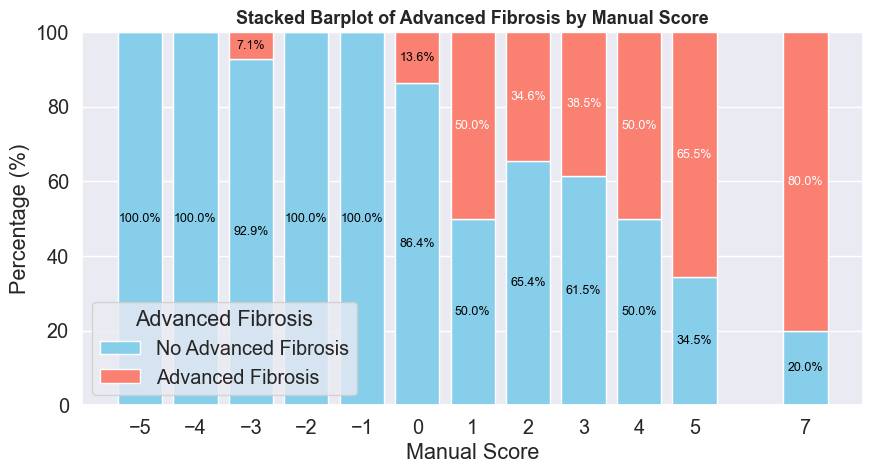

In [ ]:
# 1. Pivot table for stacking
stacked_df = (
    score_prop.pivot(
        index="Manual_Score", columns="Advanced_Fibrosis", values="Percent"
    )
    .fillna(0)
    .sort_index()
)

# 2. Plot with matplotlib directly
plt.figure(figsize=(9, 5))
labels = stacked_df.index

plt.bar(labels, stacked_df[0], label="No Advanced Fibrosis", color="skyblue")
plt.bar(
    labels,
    stacked_df[1],
    bottom=stacked_df[0],
    label="Advanced Fibrosis",
    color="salmon",
)

# Add % text
for i, score in enumerate(labels):
    y0 = stacked_df.loc[score, 0]
    y1 = stacked_df.loc[score, 1]

    if y0 > 0:
        plt.text(
            score,
            y0 / 2,
            f"{y0:.1f}%",
            ha="center",
            va="center",
            fontsize=9,
            color="black",
        )
    if y1 > 0:
        plt.text(
            score,
            y0 + y1 / 2,
            f"{y1:.1f}%",
            ha="center",
            va="center",
            fontsize=9,
            color="white" if y1 > 15 else "black",
        )

plt.title(
    "Stacked Barplot of Advanced Fibrosis by Manual Score",
    fontsize=13,
    fontweight="bold",
)
plt.xlabel("Manual Score")
plt.ylabel("Percentage (%)")
plt.legend(title="Advanced Fibrosis")
plt.xticks(labels)
plt.tight_layout()
plt.show()

AUC: 0.838
Best Cutoff: 1.0 (Youden’s J)


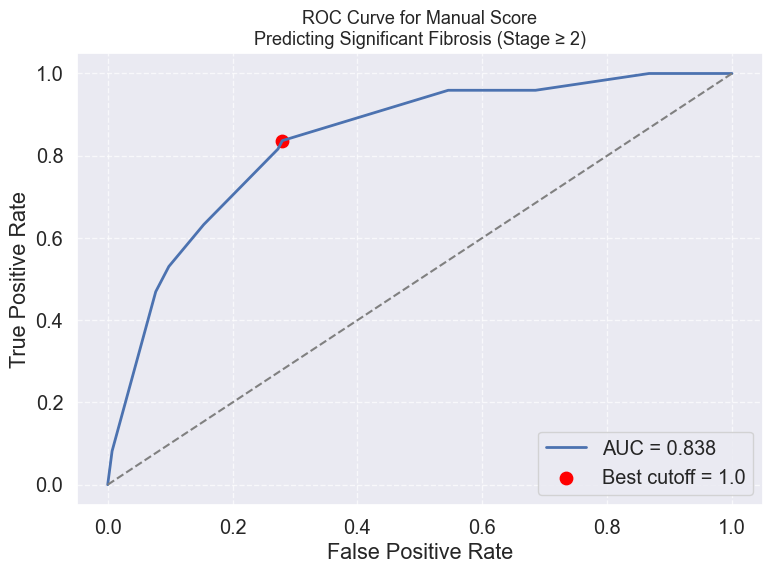

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

y_true = model_df["Advanced_Fibrosis"]
y_score = model_df["Manual_Score"]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_manual = roc_auc_score(y_true, y_score)

# Youden's J
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]

print(f"AUC: {auc_manual:.3f}")
print(f"Best Cutoff: {best_cutoff} (Youden’s J)")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_manual:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff}",
    s=80,
)
plt.title(
    "ROC Curve for Manual Score\nPredicting Significant Fibrosis (Stage ≥ 2)",
    fontsize=13,
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
model_df["Manual_Risk_Group"] = (model_df["Manual_Score"] >= best_cutoff).astype(
    int
)  # 1 = High risk, 0 = Low risk

# 간단한 교차표 확인
pd.crosstab(
    model_df["Manual_Risk_Group"],
    model_df["Advanced_Fibrosis"],
    rownames=["Risk Group"],
    colnames=["Adv. Fibrosis"],
)

Adv. Fibrosis,0,1
Risk Group,,
0,103,8
1,40,41


## Steatosis score에 대한 분석

In [ ]:
df["Severe Steatosis"] = df["Steatosis Score"].apply(lambda x: 1 if x >= 2 else 0)

In [285]:
df["Severe Steatosis"].value_counts()

Severe Steatosis
0    124
1     68
Name: count, dtype: int64

In [358]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

# 2이상이면 Severe Steatosis로 정의


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col="Severe Steatosis"
)
odds_ratio_results

,Variable,OR,95% CI Lower,95% CI Upper,p-value
27,Liver/Spleen HU_above_median,0.116758,0.057354,0.237688,3.190756e-09
24,Liver (PDFF)_above_median,6.655814,3.364680,13.166142,5.148876e-08
25,Liver (HU)_above_median,0.150245,0.075952,0.297205,5.148876e-08
28,Liver (Volume)_above_median,5.909091,3.022854,11.551122,2.052119e-07
23,CAP_above_median,5.909091,3.022854,11.551122,2.052119e-07
14,Alb_above_median,4.069264,2.161969,7.659180,1.365218e-05
31,VFA (Volume)_above_median,3.425656,1.828286,6.418646,1.213697e-04
42,TFI_above_median,3.425656,1.828286,6.418646,1.213697e-04
40,VFI_above_median,3.425656,1.828286,6.418646,1.213697e-04
37,VFA (Attenuation)_above_median,0.323149,0.173492,0.601903,3.713155e-04


In [359]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()


# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    # "PT INR",
    "Alb",
    "VFI",
    # "SFI",
    "TFI",
    # "SMI",
    "VFA (Volume)",
    # "SFA (Volume)",
    # "SMA (Volume)",
    # "Spleen (Volume)",
    "Liver (Volume)",
    "VFA (Area)",
    # "SFA (Area)",
    # "SMA (Area)",
    "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    # "Liver (HU)",
    # "Spleen (HU)",
    # "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "CAP_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Severe Steatosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Severe Steatosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print("📊 Multivariable Logistic Regression for Advanced Fibrosis (Fibrosis Stage 3-4)")

summary_df

📊 Multivariable Logistic Regression for Advanced Fibrosis (Fibrosis Stage 3-4)


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.504778,0.445438,0.000730,0.222,0.093,0.532,0.83586
Liver/Spleen HU_above_median,-1.800087,0.389927,0.000004,0.165,0.077,0.355,0.83586
Liver (Volume)_above_median,1.077292,0.389669,0.005699,2.937,1.368,6.303,0.83586
TFI_above_median,1.118083,0.403212,0.005555,3.059,1.388,6.742,0.83586
Sex,0.964454,0.396386,0.014969,2.623,1.206,5.705,0.83586


In [323]:
final_vars

['const',
 'Liver/Spleen HU_above_median',
 'Liver (Volume)_above_median',
 'TFI_above_median',
 'Sex']

In [ ]:
df["Moderate Steatosis"] = df["Steatosis Score"].apply(lambda x: 1 if x >= 1 else 0)

In [352]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

# 2이상이면 Severe Steatosis로 정의


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col="Moderate Steatosis"
)
odds_ratio_results

c:\조나현\연대 의대\연구 생활\이혜원 교수님\data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\chona\AppData\Local\Temp\ipykernel_21316\3907794918.py:28: RuntimeWarning: overflow encountered in exp
  ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])


,Variable,OR,95% CI Lower,95% CI Upper,p-value
20,LDL_above_median,1.167207e-01,0.043200,0.315364,0.000023
4,Waist_above_median,1.316000e+01,2.990314,57.915530,0.000652
27,Liver/Spleen HU_above_median,7.598784e-02,0.017267,0.334413,0.000652
23,CAP_above_median,8.157895e+00,2.335491,28.495614,0.001005
14,Alb_above_median,1.168125e+01,2.655112,51.392031,0.001147
3,Waist to Height_above_median,5.675325e+00,1.851917,17.392418,0.002378
31,VFA (Volume)_above_median,5.675325e+00,1.851917,17.392418,0.002378
34,VFA (Area)_above_median,5.675325e+00,1.851917,17.392418,0.002378
40,VFI_above_median,5.675325e+00,1.851917,17.392418,0.002378
37,VFA (Attenuation)_above_median,1.762014e-01,0.057496,0.539981,0.002378


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()


# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    # "PT INR",
    "Alb",
    "VFI",
    # "SFI",
    "TFI",
    # "SMI",
    "VFA (Volume)",
    # "SFA (Volume)",
    # "SMA (Volume)",
    # "Spleen (Volume)",
    "Liver (Volume)",
    # "VFA (Area)",
    # "SFA (Area)",
    # "SMA (Area)",
    "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    # "Liver (HU)",
    # "Spleen (HU)",
    # "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "CAP_above_median"]


# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Moderate Steatosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Moderate Steatosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]  # exclude intercept
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]
print("📊 Multivariable Logistic Regression for Moderate Steatosis Score (>=1)")

summary_df

📊 Multivariable Logistic Regression for Moderate Steatosis Score (>=1)


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,4.171655,0.846635,8.335728e-07,64.823,12.333,340.719,0.85979
Liver/Spleen HU_above_median,-2.498691,0.774790,1.259756e-03,0.082,0.018,0.375,0.85979
Waist to Height_above_median,1.817375,0.608118,2.803280e-03,6.156,1.869,20.273,0.85979
PT INR_above_median,-1.594825,0.571098,5.229292e-03,0.203,0.066,0.622,0.85979


AUC: 0.859
Best Cutoff: 0.924 | Sensitivity: 0.651 | Specificity: 0.913


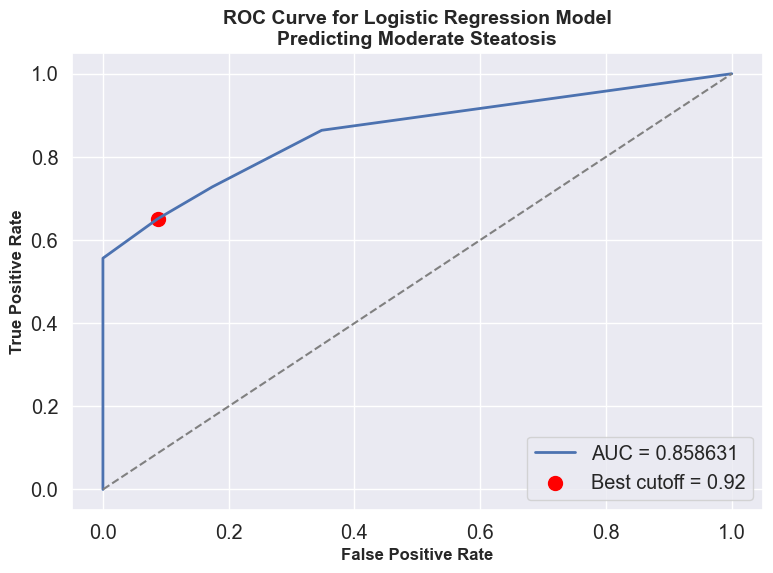

In [355]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data
df_model = df.copy()
# df_model["Moderate Steatosis"] = (
#     df_model["Steatosis Score"].isin(
#         [
#             # 1,
#             2,
#             3,
#         ]
#     )
# ).astype(int)

# Define final variables

outcome_var = "Moderate Steatosis"

# Drop NA
model_df = df_model[[outcome_var] + final_vars[1:]].dropna()
X = model_df[final_vars[1:]]
y = model_df[outcome_var]

# Add constant
X_const = sm.add_constant(X)

# Fit logistic regression model
final_model = sm.Logit(y, X_const).fit(disp=0)

# Predict probabilities on full data
y_prob = final_model.predict(X_const)
y_true = y.values

# AUC and ROC
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print metrics
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.6f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)
plt.title(
    f"ROC Curve for Logistic Regression Model\nPredicting {outcome_var}",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_LogReg_FullData.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create binary label for fibrosis (e.g., advanced fibrosis defined as stage ≥ 3)
# df = matched_df.copy()
temp_df = df.copy()

# 2이상이면 Severe Steatosis로 정의


# Function to perform univariable logistic regression and return OR, CI, and p-value
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run the analysis
odds_ratio_results = logistic_odds_ratio_analysis(
    temp_df, covariates, outcome_col="Severe Steatosis"
)
odds_ratio_results

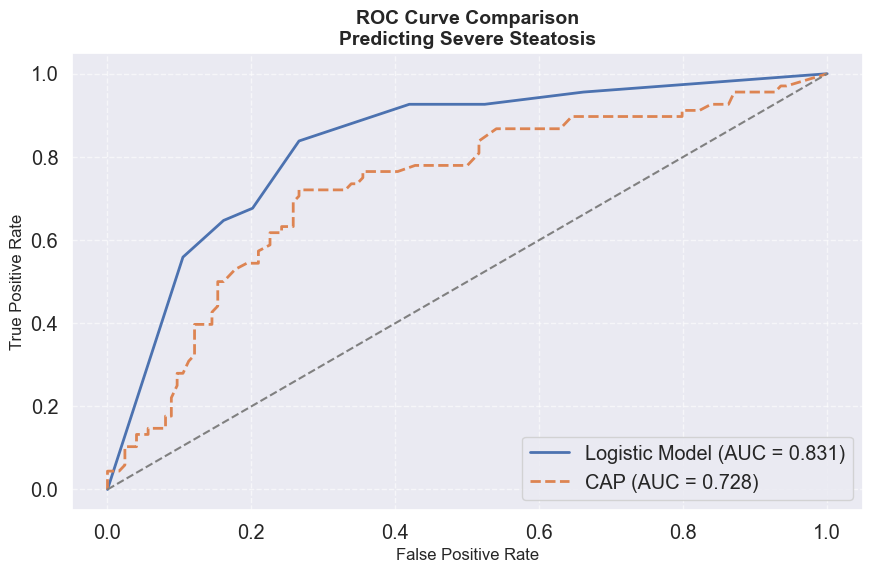

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# True label
y_true = y.values

# 모델 예측 확률
y_pred_model = final_model.predict(X[final_vars])
fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_model)
auc_model = roc_auc_score(y_true, y_pred_model)

# CAP score
cap = df_model.loc[y.index, "CAP"]
fpr_cap, tpr_cap, _ = roc_curve(y_true, cap)
auc_cap = roc_auc_score(y_true, cap)

# Plot
plt.figure(figsize=(9, 6))
plt.plot(
    fpr_model, tpr_model, label=f"Logistic Model (AUC = {auc_model:.3f})", linewidth=2
)
plt.plot(
    fpr_cap, tpr_cap, label=f"CAP (AUC = {auc_cap:.3f})", linestyle="--", linewidth=2
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(
    "ROC Curve Comparison\nPredicting Severe Steatosis", fontsize=14, fontweight="bold"
)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [310]:
# Crude OR summary for each variable in the final model
from statsmodels.api import Logit, add_constant

# Prepare results list
or_results = []

# Loop over each variable selected in the final model (excluding intercept)
for var in final_vars:
    if var == "const":
        continue  # Skip intercept

    # Subset DataFrame with the binary variable and outcome
    sub_df = df_model[[var, "Moderate Steatosis"]].dropna()

    # Count events and total for each group (0 and 1)
    for val in sorted(sub_df[var].unique(), reverse=True):
        subgroup = sub_df[sub_df[var] == val]
        total = len(subgroup)
        events = subgroup["Moderate Steatosis"].sum()
        perc = events / total * 100 if total > 0 else 0

        if val == 1:
            # Run crude logistic regression
            try:
                logit_df = add_constant(sub_df)
                model = Logit(
                    logit_df["Moderate Steatosis"], logit_df[["const", var]]
                ).fit(disp=0)
                or_ = np.exp(model.params[var])
                ci_low, ci_high = np.exp(model.conf_int().loc[var])
                pval = model.pvalues[var]
                or_str = f"{or_:.2f} ({ci_low:.2f}-{ci_high:.2f})"
            except:
                or_str, pval = "NA", "NA"
        else:
            or_str, pval = "1.00 (reference)", ""

        or_results.append(
            {
                "Variable": var,
                "Group": f"{var} = {val}",
                "Events": events,
                "Total": total,
                "Percentage": round(perc, 1),
                "Crude OR (95% CI)": or_str,
                "P-value": round(pval, 4) if pval != "" and pval != "NA" else "",
            }
        )

# Convert to DataFrame
or_results_df = pd.DataFrame(or_results)

# Export to CSV (optional)
or_results_df.to_csv(
    "Crude_OR_Table_for_Final_Model.csv", index=False, encoding="utf-8-sig"
)

# Display
or_results_df

,Variable,Group,Events,Total,Percentage,Crude OR (95% CI),P-value
0,Liver/Spleen HU_above_median,Liver/Spleen HU_above_median = 1,75,96,78.1,0.08 (0.02-0.33),0.0007
1,Liver/Spleen HU_above_median,Liver/Spleen HU_above_median = 0,94,96,97.9,1.00 (reference),
2,Liver (Volume)_above_median,Liver (Volume)_above_median = 1,90,96,93.8,3.23 (1.21-8.59),0.0189
3,Liver (Volume)_above_median,Liver (Volume)_above_median = 0,79,96,82.3,1.00 (reference),
4,TFI_above_median,TFI_above_median = 1,91,96,94.8,4.20 (1.49-11.83),0.0066
5,TFI_above_median,TFI_above_median = 0,78,96,81.2,1.00 (reference),


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Use the predicted probabilities from the final model
y_prob = final_model.predict(X[final_vars])  # predicted probabilities
y_true = y.values  # true labels

# Calculate AUC
auc = roc_auc_score(y_true, y_prob)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calculate Youden’s J statistic to find the best cutoff
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print cutoff information
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line

# Annotate best cutoff
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)

plt.title(
    "ROC Curve for Logistic Regression Model\nPredicting Advanced Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Optional: Save the figure
plt.savefig("ROC_LogReg_Advanced_Fibrosis.png", dpi=600, bbox_inches="tight")
plt.show()

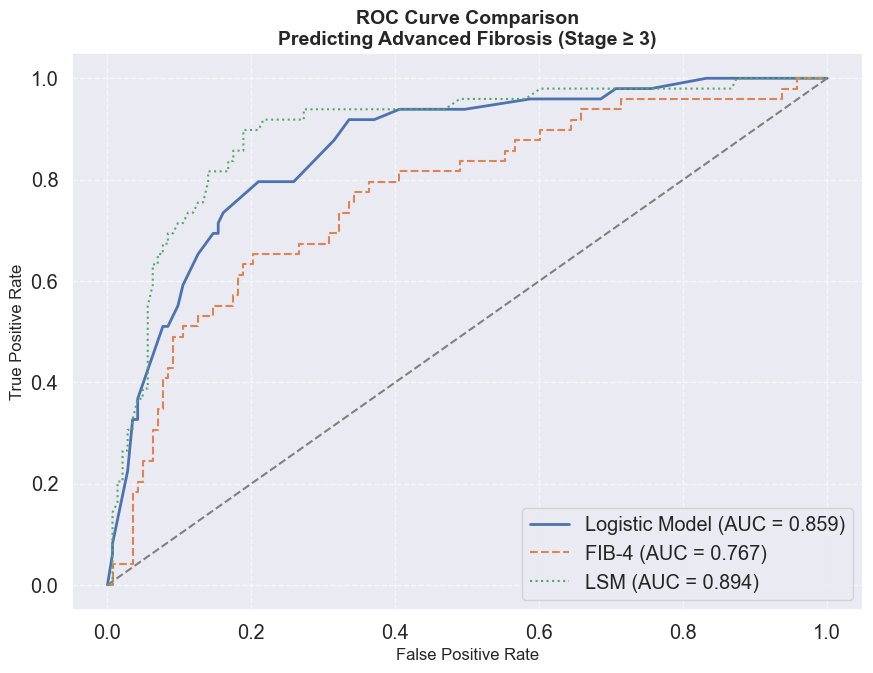

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# true label
y_true = y.values  # y는 Advanced_Fibrosis

# Logistic regression
y_prob_model = final_model.predict(X[final_vars])
fpr_model, tpr_model, _ = roc_curve(y_true, y_prob_model)
auc_model = roc_auc_score(y_true, y_prob_model)

# FIB-4 score
fib4 = df_model.loc[y.index, "FIB-4"]
fpr_fib4, tpr_fib4, _ = roc_curve(y_true, fib4)
auc_fib4 = roc_auc_score(y_true, fib4)

# LSM score
lsm = df_model.loc[y.index, "LSM"]
fpr_lsm, tpr_lsm, _ = roc_curve(y_true, lsm)
auc_lsm = roc_auc_score(y_true, lsm)

# Plot
plt.figure(figsize=(9, 7))
plt.plot(
    fpr_model, tpr_model, label=f"Logistic Model (AUC = {auc_model:.3f})", linewidth=2
)
plt.plot(fpr_fib4, tpr_fib4, label=f"FIB-4 (AUC = {auc_fib4:.3f})", linestyle="--")
plt.plot(fpr_lsm, tpr_lsm, label=f"LSM (AUC = {auc_lsm:.3f})", linestyle=":")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title(
    "ROC Curve Comparison\nPredicting Advanced Fibrosis (Stage ≥ 3)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("ROC_Comparison_Advanced_Fibrosis.png", dpi=600, bbox_inches="tight")
plt.show()

In [197]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Define the outcome variable
df_model["Advanced_Fibrosis"] = (df_model["Steatosis Score"].isin([2, 3])).astype(
    int
)  # (df["Fibrosis"] >= 2).astype(int)

# (df_model["Fibrosis"] >= 2).astype(int)

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    # "VFA (Volume)",
    # "SFA (Volume)",
    # "SMA (Volume)",
    "Spleen (Volume)",
    # "VFA (Area)",
    # "SFA (Area)",
    # "SMA (Area)",
    # "VFA (Attenuation)",
    # "SFA (Attenuation)",
    # "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = [
    "당뇨병/당뇨병 전단계 유무",
    # "당뇨병/당뇨병 전단계 유무2",
    "Sex",
]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]

# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Advanced_Fibrosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Advanced_Fibrosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def backward_stepwise_aic(X, y):
    remaining_vars = X.columns.tolist()
    current_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    current_aic = current_model.aic

    improved = True
    while improved and len(remaining_vars) > 1:
        aic_with_var_removed = []
        for var in remaining_vars:
            if var == "const":
                continue  # Don't remove intercept
            temp_vars = [v for v in remaining_vars if v != var]
            try:
                temp_model = sm.Logit(y, X[temp_vars]).fit(disp=0)
                aic_with_var_removed.append((var, temp_model.aic))
            except:
                continue

        if not aic_with_var_removed:
            break

        best_var_to_remove, best_aic = min(aic_with_var_removed, key=lambda x: x[1])
        if best_aic < current_aic:
            remaining_vars.remove(best_var_to_remove)
            current_aic = best_aic
        else:
            improved = False

    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run backward stepwise
final_model, final_vars = backward_stepwise_aic(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]

summary_df

,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-2.076563,0.510343,0.000047,0.125,0.046,0.341,0.7791
PLT_above_median,1.306655,0.371640,0.000438,3.694,1.783,7.653,0.7791
AST_above_median,1.108543,0.354282,0.001754,3.030,1.513,6.067,0.7791
PT INR_above_median,-0.679366,0.373128,0.068648,0.507,0.244,1.053,0.7791
Sex,0.962017,0.369568,0.009239,2.617,1.268,5.400,0.7791
Age_above_median,-0.606389,0.372263,0.103329,0.545,0.263,1.131,0.7791
당뇨병/당뇨병 전단계 유무,0.459412,0.204675,0.024795,1.583,1.060,2.365,0.7791


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Define the outcome variable
df_model["Advanced_Fibrosis"] = (df_model["Steatosis Score"].isin([3])).astype(
    int
)  # (df["Fibrosis"] >= 2).astype(int)

# (df_model["Fibrosis"] >= 2).astype(int)

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "Spleen (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]
prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = ["당뇨병/당뇨병 전단계 유무", "당뇨병/당뇨병 전단계 유무2", "Sex"]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]

# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Advanced_Fibrosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Advanced_Fibrosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def forward_stepwise_pval(X, y, threshold_in=0.05):
    initial_vars = ["const"] if "const" in X.columns else []
    remaining_vars = [v for v in X.columns if v != "const"]
    selected_vars = initial_vars[:]

    while remaining_vars:
        pvals = {}
        for var in remaining_vars:
            try:
                model = sm.Logit(y, X[selected_vars + [var]]).fit(disp=0)
                pval = model.pvalues[var]
                pvals[var] = pval
            except:
                continue
        if not pvals:
            break

        best_var = min(pvals, key=pvals.get)
        if pvals[best_var] < threshold_in:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
        else:
            break

    final_model = sm.Logit(y, X[selected_vars]).fit(disp=0)
    return final_model, selected_vars


# Run backward stepwise
final_model, final_vars = forward_stepwise_pval(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]

summary_df

,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.821612,0.324985,2.079817e-08,0.162,0.086,0.306,0.68697
Age_above_median,-1.815974,0.786621,2.096719e-02,0.163,0.035,0.760,0.68697


In [140]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve

# Use a copy of the original DataFrame
df_model = df.copy()

# Define the outcome variable
df_model["Advanced_Fibrosis"] = (df_model["Fibrosis"].isin([3, 4])).astype(
    int
)  # (df["Fibrosis"] >= 2).astype(int)

# (df_model["Fibrosis"] >= 2).astype(int)

# Filter the covariates from previous univariable results
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    "당뇨병/당뇨병 전단계 유무2",
    "PLT",
    "PT INR",
    "Alb",
    "VFI",
    "SFI",
    "TFI",
    "SMI",
    "Spleen (Volume)",
    "VFA (Area)",
    "SFA (Area)",
    "SMA (Area)",
    "VFA (Attenuation)",
    "SFA (Attenuation)",
    "SMA (Attenuation)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Step 2: Replace specific ones (like 'DM_above_median' and 'Sex_above_median') with original names
replace_back = ["당뇨병/당뇨병 전단계 유무", "당뇨병/당뇨병 전단계 유무2", "Sex"]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
# Exclude LSM from modeling
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]

# Drop rows with missing values for selected covariates and outcome
model_df = df_model[["Advanced_Fibrosis"] + significant_vars].dropna()

# Define X and y
X = model_df[significant_vars]
y = model_df["Advanced_Fibrosis"]

# Add constant for intercept
X = sm.add_constant(X)


# Perform backward stepwise logistic regression
def forward_stepwise_aic(X, y):
    initial_vars = ["const"] if "const" in X.columns else []
    remaining_vars = [v for v in X.columns if v != "const"]
    selected_vars = initial_vars[:]

    current_aic = float("inf")
    improved = True

    while improved and remaining_vars:
        aic_with_var_added = []
        for var in remaining_vars:
            try:
                model = sm.Logit(y, X[selected_vars + [var]]).fit(disp=0)
                aic = model.aic
                aic_with_var_added.append((var, aic))
            except:
                continue

        if not aic_with_var_added:
            break

        best_var, best_aic = min(aic_with_var_added, key=lambda x: x[1])
        if best_aic < current_aic:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
            current_aic = best_aic
        else:
            improved = False

    final_model = sm.Logit(y, X[selected_vars]).fit(disp=0)
    return final_model, selected_vars


# Run backward stepwise
final_model, final_vars = forward_stepwise_aic(X, y)

# Predict probabilities and calculate AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract the summary table
summary_df = final_model.summary2().tables[1]

# Calculate Odds Ratios and 95% CI
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Optional: Rearrange columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]

summary_df

,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-0.709451,0.401017,0.076872,0.492,0.224,1.080,0.779
PLT_above_median,-0.986796,0.397080,0.012950,0.373,0.171,0.812,0.779
PT INR_above_median,1.283592,0.397850,0.001254,3.610,1.655,7.873,0.779
SMA (Area)_above_median,-1.161282,0.409190,0.004540,0.313,0.140,0.698,0.779
Liver/Spleen HU_above_median,0.652230,0.379845,0.085962,1.920,0.912,4.042,0.779


In [45]:
prof_vars_above_median

['Age_above_median',
 'Waist to Height_above_median',
 'BMI_above_median',
 'Sex',
 'AST_above_median',
 'ALT_above_median',
 '당뇨병/당뇨병 전단계 유무',
 '당뇨병/당뇨병 전단계 유무2',
 'PLT_above_median',
 'PT INR_above_median',
 'Alb_above_median',
 'VFI_above_median',
 'SFI_above_median',
 'TFI_above_median',
 'SMI_above_median',
 'Spleen (Volume)_above_median',
 'VFA (Area)_above_median',
 'SFA (Area)_above_median',
 'SMA (Area)_above_median',
 'VFA (Attenuation)_above_median',
 'SFA (Attenuation)_above_median',
 'SMA (Attenuation)_above_median',
 'Liver/Spleen Volume_above_median',
 'Liver/Spleen HU_above_median',
 'Liver (HU)_above_median',
 'Spleen (HU)_above_median',
 'Liver (PDFF)_above_median']

In [198]:
# Crude OR summary for each variable in the final model
from statsmodels.api import Logit, add_constant

# Prepare results list
or_results = []

# Loop over each variable selected in the final model (excluding intercept)
for var in final_vars:
    if var == "const":
        continue  # Skip intercept

    # Subset DataFrame with the binary variable and outcome
    sub_df = df_model[[var, "Advanced_Fibrosis"]].dropna()

    # Count events and total for each group (0 and 1)
    for val in sorted(sub_df[var].unique(), reverse=True):
        subgroup = sub_df[sub_df[var] == val]
        total = len(subgroup)
        events = subgroup["Advanced_Fibrosis"].sum()
        perc = events / total * 100 if total > 0 else 0

        if val == 1:
            # Run crude logistic regression
            try:
                logit_df = add_constant(sub_df)
                model = Logit(
                    logit_df["Advanced_Fibrosis"], logit_df[["const", var]]
                ).fit(disp=0)
                or_ = np.exp(model.params[var])
                ci_low, ci_high = np.exp(model.conf_int().loc[var])
                pval = model.pvalues[var]
                or_str = f"{or_:.2f} ({ci_low:.2f}-{ci_high:.2f})"
            except:
                or_str, pval = "NA", "NA"
        else:
            or_str, pval = "1.00 (reference)", ""

        or_results.append(
            {
                "Variable": var,
                "Group": f"{var} = {val}",
                "Events": events,
                "Total": total,
                "Percentage": round(perc, 1),
                "Crude OR (95% CI)": or_str,
                "P-value": round(pval, 4) if pval != "" and pval != "NA" else "",
            }
        )

# Convert to DataFrame
or_results_df = pd.DataFrame(or_results)

# Export to CSV (optional)
or_results_df.to_csv(
    "Crude_OR_Table_for_Final_Model.csv", index=False, encoding="utf-8-sig"
)

# Display
or_results_df

,Variable,Group,Events,Total,Percentage,Crude OR (95% CI),P-value
0,PLT_above_median,PLT_above_median = 1,46,96,47.9,3.50 (1.85-6.60),0.0001
1,PLT_above_median,PLT_above_median = 0,20,96,20.8,1.00 (reference),
2,AST_above_median,AST_above_median = 1,41,94,43.6,2.26 (1.23-4.16),0.0089
3,AST_above_median,AST_above_median = 0,25,98,25.5,1.00 (reference),
4,PT INR_above_median,PT INR_above_median = 1,24,89,27.0,0.54 (0.29-0.99),0.0457
5,PT INR_above_median,PT INR_above_median = 0,42,103,40.8,1.00 (reference),
6,Sex,Sex = 1,38,84,45.2,2.36 (1.28-4.34),0.0056
7,Sex,Sex = 0,28,108,25.9,1.00 (reference),
8,Age_above_median,Age_above_median = 1,24,95,25.3,0.44 (0.24-0.82),0.0091
9,Age_above_median,Age_above_median = 0,42,97,43.3,1.00 (reference),


AUC: 0.859
Best Cutoff: 0.259 | Sensitivity: 0.796 | Specificity: 0.790


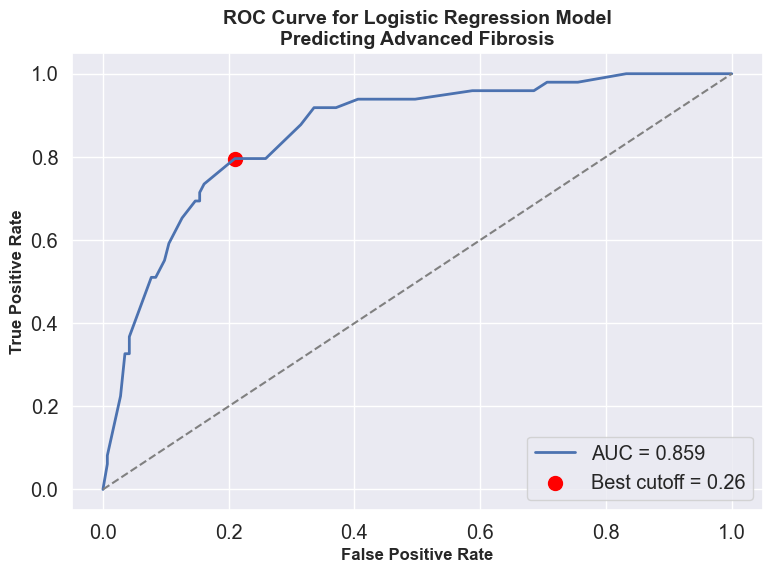

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Use the predicted probabilities from the final model
y_prob = final_model.predict(X[final_vars])  # predicted probabilities
y_true = y.values  # true labels

# Calculate AUC
auc = roc_auc_score(y_true, y_prob)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calculate Youden’s J statistic to find the best cutoff
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print cutoff information
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line

# Annotate best cutoff
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)

plt.title(
    "ROC Curve for Logistic Regression Model\nPredicting Advanced Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Optional: Save the figure
plt.savefig("ROC_LogReg_Advanced_Fibrosis.png", dpi=600, bbox_inches="tight")
plt.show()

In [330]:
final_vars

['const',
 'Liver/Spleen HU_above_median',
 'Liver (Volume)_above_median',
 'TFI_above_median',
 'Sex']

AUC: 0.807
Best Cutoff: 0.965 | Sensitivity: 0.509 | Specificity: 1.000


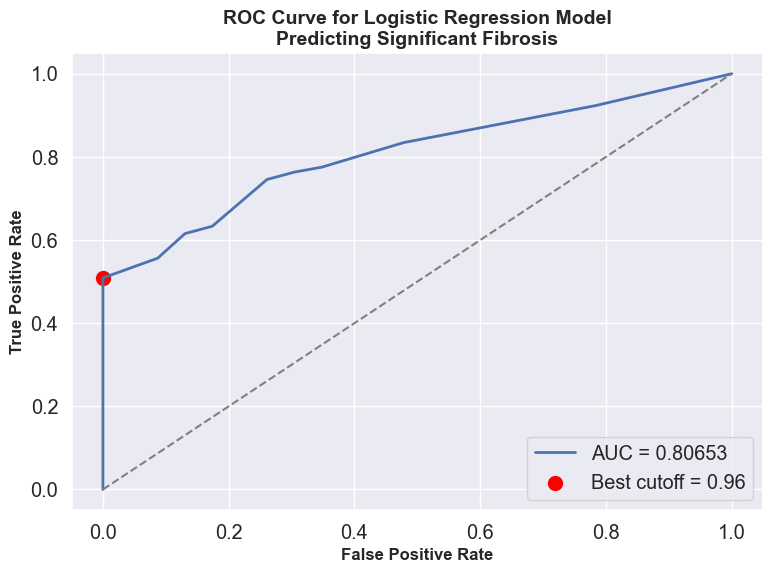

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data
df_model = df.copy()
df_model["Advanced_Fibrosis"] = (df_model["Steatosis Score"].isin([1, 2, 3])).astype(
    int
)

# Define final variables
final_vars = [
    "Liver/Spleen HU_above_median",
    "Liver (Volume)_above_median",
    "TFI_above_median",
    "Sex",
]

# Drop NA
model_df = df_model[["Advanced_Fibrosis"] + final_vars].dropna()
X = model_df[final_vars]
y = model_df["Advanced_Fibrosis"]

# Add constant
X_const = sm.add_constant(X)

# Fit logistic regression model
final_model = sm.Logit(y, X_const).fit(disp=0)

# Predict probabilities on full data
y_prob = final_model.predict(X_const)
y_true = y.values

# AUC and ROC
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print metrics
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)
plt.title(
    "ROC Curve for Logistic Regression Model\nPredicting Significant Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_LogReg_FullData.png", dpi=600, bbox_inches="tight")
plt.show()

In [205]:
df.columns.tolist()

['ID',
 'Sex',
 'Age',
 'Birth Date',
 'Steatosis Score',
 'NASH',
 'Fibrosis Stage',
 'NAFLD Type',
 'Death',
 'Death Date',
 'Weight',
 'Height',
 'Waist to Height',
 'Waist',
 'BMI',
 'Last F/U',
 'Smoking',
 'Ascites',
 'Ascites_Date',
 'VB',
 'VB_Date',
 'HEP',
 'HEP_Date',
 'HRS',
 'HRS_Date',
 'LT',
 'LT_Date',
 'FS_date',
 'CT_B Date',
 'SBP',
 'DBP',
 'LSM',
 'CAP',
 'AST',
 'ALT',
 'FIB-4',
 '당뇨병/당뇨병 전단계 유무',
 'PLT',
 'PT INR',
 'Alb',
 'Glucose',
 'TG',
 'VFI',
 'SFI',
 'TFI',
 'SMI',
 'VFA (Volume)',
 'SFA (Volume)',
 'SMA (Volume)',
 'Spleen (Volume)',
 'Liver (Volume)',
 'VFA (Area)',
 'SFA (Area)',
 'SMA (Area)',
 'VFA (Attenuation)',
 'SFA (Attenuation)',
 'SMA (Attenuation)',
 'Liver/Spleen Volume',
 'Liver/Spleen HU',
 'Liver (HU)',
 'Spleen (HU)',
 'Liver (PDFF)',
 'LRE',
 'LRE Date',
 'Fibrosis',
 'Fibrosis_group',
 'LRE Original',
 'Liver/Spleen Volume_above_median',
 'VFA (Volume)_above_median',
 'SMA (Attenuation)_above_median',
 'Liver (PDFF)_above_median',
 'SF

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Binary label for significant fibrosis (Fibrosis stage 3–4)
df["Sig_Fibrosis"] = (df["Fibrosis"] >= 2).astype(int)


# Univariable logistic regression function
def logistic_odds_ratio_analysis(df, covariates, outcome_col):
    results = []

    for var in covariates:
        try:
            sub_df = df[[outcome_col, var]].dropna()

            if sub_df[var].nunique() <= 1:
                print(f"⚠️ Skipping '{var}' — only one unique value.")
                continue

            sub_df = sm.add_constant(sub_df)
            model = sm.Logit(sub_df[outcome_col], sub_df[["const", var]]).fit(disp=0)

            odds_ratio = np.exp(model.params[var])
            conf = model.conf_int().loc[var]
            ci_lower, ci_upper = np.exp(conf[0]), np.exp(conf[1])

            pval = model.pvalues[var]

            results.append(
                {
                    "Variable": var,
                    "OR": odds_ratio,
                    "95% CI Lower": ci_lower,
                    "95% CI Upper": ci_upper,
                    "p-value": pval,
                }
            )
        except Exception as e:
            print(f"❌ Error with '{var}': {e}")
            continue

    return pd.DataFrame(results).sort_values(by="p-value")


# Run univariable logistic regression for Significant Fibrosis
odds_ratio_results = logistic_odds_ratio_analysis(
    df, covariates, outcome_col="Sig_Fibrosis"
)

# Display
print("📊 Univariable Logistic Regression for Significant Fibrosis (Stage 3–4)")
display(odds_ratio_results)

⚠️ Skipping 'Glucose_above_median' — only one unique value.
📊 Univariable Logistic Regression for Significant Fibrosis (Stage 3–4)


,Variable,OR,95% CI Lower,95% CI Upper,p-value
9,LSM_above_median,10.270707,5.132177,20.554128,4.688266e-11
7,FIB-4_above_median,5.553846,2.930994,10.523803,1.460092e-07
24,SMA (Volume)_above_median,0.200000,0.106360,0.376082,5.876520e-07
2,Age_above_median,4.687500,2.506858,8.765019,1.311612e-06
1,AST_above_median,3.615238,1.965118,6.650972,3.596876e-05
8,Height_above_median,0.294390,0.159398,0.543705,9.357903e-05
25,SMI_above_median,0.327731,0.179368,0.598813,2.862460e-04
22,SMA (Area)_above_median,0.360000,0.197854,0.655027,8.219562e-04
15,PLT_above_median,0.432836,0.239576,0.781995,5.523513e-03
26,Sex,0.456323,0.250177,0.832334,1.051467e-02


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Copy original DataFrame
df_model = df.copy()

# Define outcome variable: Significant Fibrosis = Stage 3 or 4
df_model["Sig_Fibrosis"] = (df_model["Fibrosis"] >= 2).astype(int)

# Covariates used for modeling (above-median or categorical as-is)
prof_vars = [
    "Age",
    "Waist to Height",
    "BMI",
    "Sex",
    "AST",
    "ALT",
    "당뇨병/당뇨병 전단계 유무",
    "PLT",
    "PT INR",
    "Alb",
    "VFA (Volume)",
    "SFA (Volume)",
    "SMA (Volume)",
    "Spleen (Volume)",
    "Liver (Volume)",
    "Liver/Spleen Volume",
    "Liver/Spleen HU",
    "Liver (HU)",
    "Spleen (HU)",
    "Liver (PDFF)",
]

prof_vars_above_median = [var + "_above_median" for var in prof_vars]

# Replace categorical vars to use raw (not above-median)
replace_back = ["당뇨병/당뇨병 전단계 유무", "Sex"]
prof_vars_above_median = [
    (
        var
        if var.replace("_above_median", "") not in replace_back
        else var.replace("_above_median", "")
    )
    for var in prof_vars_above_median
]

# Select significant variables from univariable results
significant_vars = list(
    set(odds_ratio_results[odds_ratio_results["p-value"] < 0.05]["Variable"])
    & set(prof_vars_above_median)
)
significant_vars = [var for var in significant_vars if var != "LSM_above_median"]

# Build model input
model_df = df_model[["Sig_Fibrosis"] + significant_vars].dropna()
X = sm.add_constant(model_df[significant_vars])
y = model_df["Sig_Fibrosis"]


# Backward stepwise logistic regression
def backward_stepwise(X, y, threshold_out=0.05):
    remaining_vars = X.columns.tolist()
    while len(remaining_vars) > 1:
        model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
        pvals = model.pvalues.iloc[1:]
        max_pval = pvals.max()
        if max_pval > threshold_out:
            excluded_var = pvals.idxmax()
            remaining_vars.remove(excluded_var)
        else:
            break
    final_model = sm.Logit(y, X[remaining_vars]).fit(disp=0)
    return final_model, remaining_vars


# Run model
final_model, final_vars = backward_stepwise(X, y)

# Predict and compute AUC
y_pred = final_model.predict(X[final_vars])
auc = roc_auc_score(y, y_pred)

# Extract results
summary_df = final_model.summary2().tables[1]
summary_df["OR"] = summary_df["Coef."].apply(lambda x: round(np.exp(x), 3))
summary_df["CI Lower"] = (summary_df["Coef."] - 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["CI Upper"] = (summary_df["Coef."] + 1.96 * summary_df["Std.Err."]).apply(
    lambda x: round(np.exp(x), 3)
)
summary_df["AUC"] = round(auc, 5)

# Reorder columns
summary_df = summary_df[
    ["Coef.", "Std.Err.", "P>|z|", "OR", "CI Lower", "CI Upper", "AUC"]
]

# Display
print(
    "📊 Multivariable Logistic Regression for Significant Fibrosis (Fibrosis Stage >=2)"
)
display(summary_df)

📊 Multivariable Logistic Regression for Significant Fibrosis (Fibrosis Stage >=2)


,Coef.,Std.Err.,P>|z|,OR,CI Lower,CI Upper,AUC
const,-1.403391,0.400163,0.000453,0.246,0.112,0.538,0.8153
SMA (Volume)_above_median,-1.451989,0.372864,0.000099,0.234,0.113,0.486,0.8153
AST_above_median,1.514182,0.363946,0.000032,4.546,2.227,9.277,0.8153
Age_above_median,1.184614,0.367915,0.001283,3.269,1.590,6.724,0.8153
당뇨병/당뇨병 전단계 유무,0.441272,0.203844,0.030407,1.555,1.043,2.318,0.8153


AUC: 0.815
Best Cutoff: 0.461 | Sensitivity: 0.688 | Specificity: 0.835


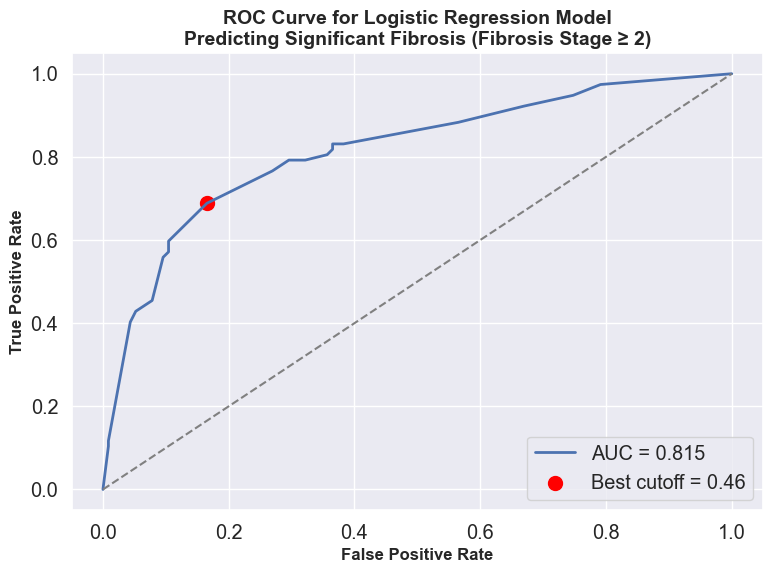

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Use the predicted probabilities from the final model
y_prob = final_model.predict(X[final_vars])  # predicted probabilities
y_true = y.values  # true labels

# Calculate AUC
auc = roc_auc_score(y_true, y_prob)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calculate Youden’s J statistic to find the best cutoff
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print cutoff information
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line

# Annotate best cutoff
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)

plt.title(
    "ROC Curve for Logistic Regression Model\nPredicting Significant Fibrosis (Fibrosis Stage ≥ 2)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Optional: Save the figure
plt.savefig("ROC_LogReg_Significant_Fibrosis.png", dpi=600, bbox_inches="tight")
plt.show()

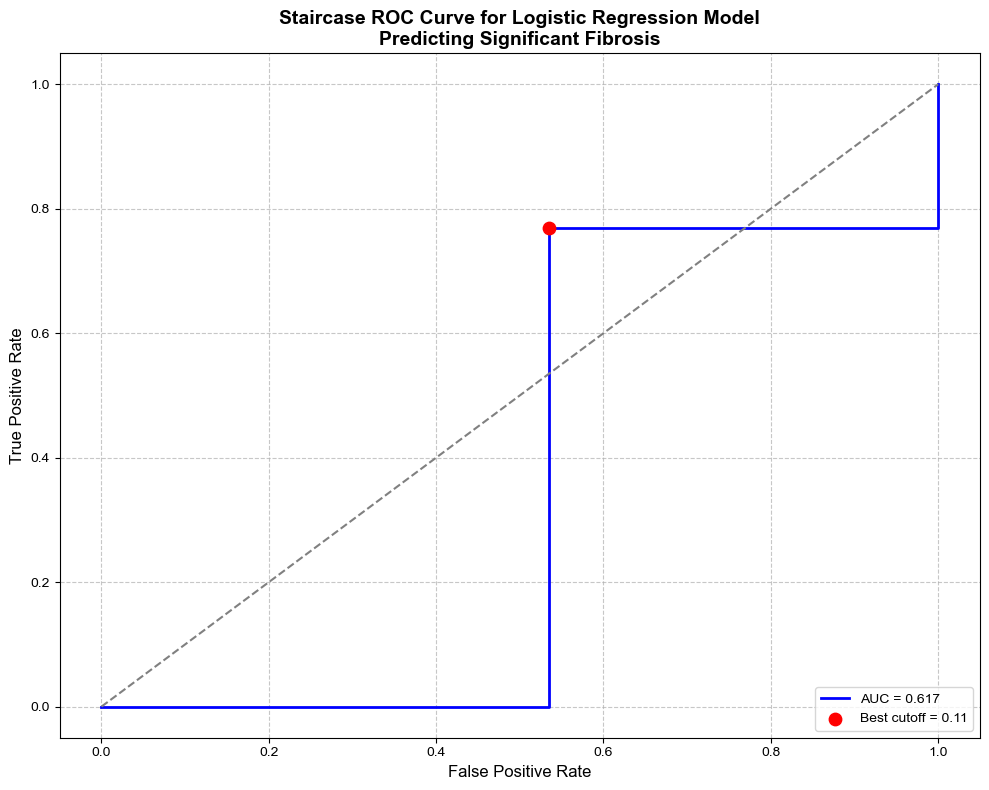

In [ ]:
# Plot staircase-style ROC curve with all steps
plt.figure(figsize=(10, 8))  # Increase size for better visibility
plt.step(fpr, tpr, where="post", label=f"AUC = {auc:.3f}", linewidth=2, color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line

# Annotate the best cutoff
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=80,
    zorder=5,
)

# Add grid and axes labels
plt.title(
    "Staircase ROC Curve for Logistic Regression Model\nPredicting Significant Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig("ROC_LogReg_Validation_Step.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
unique_probs = np.unique(y_pred)
print(f"Number of unique predicted probabilities: {len(unique_probs)}")
print("Sample unique probabilities:", unique_probs[:10])

Number of unique predicted probabilities: 17
Sample unique probabilities: [0.05429343 0.09927563 0.13345689 0.15495608 0.17165587 0.22819993
 0.26037567 0.2846102  0.2846102  0.32972014]


In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np


def bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, ci=0.95, random_state=42):
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)

    np.random.seed(random_state)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred_prob[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)

    return round(lower, 3), round(upper, 3)


ci_lower, ci_upper = bootstrap_auc_ci(y_true, y_pred)
print(f"95% CI for AUC: {ci_lower} – {ci_upper}")

95% CI for AUC: 0.261 – 0.548


# Train Val 쪼개서

In [53]:
final_vars

['Liver/Spleen HU_above_median']

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prepare data
df_model = df.copy()
df_model["Advanced_Fibrosis"] = (df_model["Steatosis Score"].isin([1, 2, 3, 4])).astype(
    int
)


final_vars = [var for var in final_vars if var != "const"]
final_vars = [
    "Waist to Height_above_median",
    "PT INR_above_median",
    "VFI_above_median",
    "Liver/Spleen HU_above_median",
]

# Drop NA
model_df = df_model[["Advanced_Fibrosis"] + final_vars].dropna()
X = model_df[final_vars]
y = model_df["Advanced_Fibrosis"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Add constant
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

final_vars = [var for var in final_vars if var != "const"]
final_model = sm.Logit(y, X[final_vars]).fit(disp=0)

# Predict on test set
y_prob = final_model.predict(X_test_const[final_vars])
y_true = y_test.values

# AUC and ROC
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_cutoff = thresholds[best_idx]
best_sens = tpr[best_idx]
best_spec = 1 - fpr[best_idx]

# Print metrics
print(f"AUC: {auc:.3f}")
print(
    f"Best Cutoff: {best_cutoff:.3f} | Sensitivity: {best_sens:.3f} | Specificity: {best_spec:.3f}"
)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)
plt.title(
    "ROC Curve for Logistic Regression Model\nPredicting Significant Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_LogReg_Validation.png", dpi=600, bbox_inches="tight")
plt.show()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Plot staircase-style ROC curve
plt.figure(figsize=(8, 6))
plt.step(fpr, tpr, where="post", label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random guess line
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best cutoff = {best_cutoff:.2f}",
    s=100,
)

plt.title(
    "Staircase ROC Curve for Logistic Regression Model\nPredicting Significant Fibrosis",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_LogReg_Validation_Step.png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np


def bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, ci=0.95, random_state=42):
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)

    np.random.seed(random_state)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred_prob[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = np.percentile(sorted_scores, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_scores, (1 + ci) / 2 * 100)

    return round(lower, 3), round(upper, 3)


ci_lower, ci_upper = bootstrap_auc_ci(y_true, y_prob)
print(f"95% CI for AUC: {ci_lower} – {ci_upper}")

In [ ]:
final_vars